<a href="https://colab.research.google.com/github/WUIJOA/TFM/blob/main/wind_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Potencia del viento**

### **Declaraciones o comandos**

In [ ]:
# Instalación de bibliotecas
!pip install --upgrade scikit-learn
!pip install --upgrade mealpy

# Importación de la biblioteca estandar
import io
import os
import time
import joblib

# Importaciones de bibliotecas de terceros

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files, drive
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import circmean
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger
from tensorflow.keras.regularizers import l2
from mealpy.utils.problem import Problem
from mealpy.utils.space import IntegerVar, FloatVar
from mealpy.swarm_based.WOA import OriginalWOA
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 92.8 MB/s eta 0:00:00


### **Montaje del drive**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importar los conjuntos de datos**

**Dirección de viento**

In [ ]:
# Cargo dataset de dirección
ruta_archivo = 'drive/MyDrive/viento/Direccion_Viento.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df_direccion = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de la dirección del viento')
print('\n\nDimensiones\n')
print(df_direccion.shape)
print('\nTipos de datos\n')
print(df_direccion.dtypes)
print('\nPrimeras filas\n')
print(df_direccion.head())
print('\nÚltimas filas\n')
print(df_direccion.tail())

Información del conjunto de datos de la dirección del viento


Dimensiones

(1251203, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        17015010           104  02/25/2017 12:20:00 AM             2.9   
1        17015010           104  12/11/2017 02:50:00 AM            19.6   
2        29045190           104  07/18/2017 01:30:00 PM            22.7   
3        17015010           104  10/22/2015 03:40:00 PM           140.2   
4        17015010           104  04/24/2019 01:00:00 AM           106.1   

                  NombreEstacion            Departamento   Muni

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_direccion['FechaObservacion'] = pd.to_datetime(df_direccion['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_direccion.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_direccion.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:50:00 2019-02-26 09:10:00  143969
15015050       2025-03-08 23:50:00 2022-03-18 00:00:00   36123
17015010       2025-01-01 03:50:00 2014-06-27 11:20:00  409275
17025020       2025-03-08 23:50:00 2021-06-03 08:00:00  239199
29045190       2025-03-08 23:50:00 2013-05-14 22:00:00  422637


**Humedad**

In [ ]:
# Cargo dataset de humedad
ruta_archivo = 'drive/MyDrive/viento/Humedad.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df_humedad = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de humedad')
print('\n\nDimensiones\n')
print(df_humedad.shape)
print('\nTipos de datos\n')
print(df_humedad.dtypes)
print('\nPrimeras filas\n')
print(df_humedad.head())
print('\nÚltimas filas\n')
print(df_humedad.tail())

Información del conjunto de datos de humedad


Dimensiones

(1290084, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        17015010            27  04/13/2019 11:00:00 PM            81.0   
1        17015010            27  11/23/2017 01:00:00 PM            85.0   
2        17015010            27  11/29/2014 11:00:00 PM            76.0   
3        17015010            27  05/31/2019 02:00:00 PM            69.0   
4        29045190            27  08/19/2015 01:00:00 PM            55.0   

                  NombreEstacion            Departamento   Municipio  \
0  APTO

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_humedad['FechaObservacion'] = pd.to_datetime(df_humedad['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_humedad.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_humedad.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:00:00 2019-02-26 10:00:00   27276
15015050       2025-03-08 23:00:00 2022-03-18 00:00:00  154948
17015010       2025-03-08 23:58:00 2014-06-27 12:00:00  514559
17025020       2025-03-08 23:00:00 2021-06-03 08:00:00  109350
29045190       2025-03-08 23:58:00 2013-05-07 18:00:00  483951


**Precipitación**

In [ ]:
# Cargo dataset de precipitación
ruta_archivo = "drive/MyDrive/viento/Precipitacion.csv"

# Cargar el archivo CSV en un DataFrame de pandas
df_precipitacion = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de precipitación')
print('\n\nDimensiones\n')
print(df_precipitacion.shape)
print('\nTipos de datos\n')
print(df_precipitacion.dtypes)
print('\nPrimeras filas\n')
print(df_precipitacion.head())
print('\nÚltimas filas\n')
print(df_precipitacion.tail())

Información del conjunto de datos de precipitación


Dimensiones

(2156615, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        29045190           240  02/26/2025 09:50:00 AM             0.0   
1        29045190           257  02/26/2025 05:04:00 AM             0.0   
2        29045190           257  02/26/2025 08:00:00 AM             0.0   
3        17015010           257  02/26/2025 04:46:00 AM             0.0   
4        29045190           257  02/26/2025 11:00:00 PM             0.0   

                NombreEstacion  \
0      AEROPUERTO E. CORTISSOZ   
1    

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_precipitacion['FechaObservacion'] = pd.to_datetime(df_precipitacion['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_precipitacion.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_precipitacion.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:50:00 2019-02-26 09:10:00  166751
15015050       2025-03-08 23:50:00 2022-03-18 00:00:00  177273
17015010       2025-03-08 23:58:00 2014-06-27 11:20:00  871378
17025020       2025-03-08 23:50:00 2021-06-03 08:00:00  235138
29045190       2025-03-08 23:58:00 2016-12-31 23:10:00  706075


**Presión atmosférica**

In [ ]:
# Cargo dataset de presión atmosférica
ruta_archivo = "drive/MyDrive/viento/Presion_atmosferica.csv"

# Cargar el archivo CSV en un DataFrame de pandas
df_presion = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de presión atmosférica')
print('\n\nDimensiones\n')
print(df_presion.shape)
print('\nTipos de datos\n')
print(df_presion.dtypes)
print('\nPrimeras filas\n')
print(df_presion.head())
print('\nÚltimas filas\n')
print(df_presion.tail())

Información del conjunto de datos de presión atmosférica


Dimensiones

(1269382, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        29045190           255  09/10/2018 10:00:00 AM          1009.3   
1        17015010           255  07/14/2017 05:00:00 AM          1014.0   
2        29045190           255  03/13/2018 08:00:00 PM          1008.0   
3        14015010           255  07/31/2019 10:00:00 PM          1008.5   
4        29045190           255  08/13/2018 12:00:00 PM          1006.9   

                  NombreEstacion            Departamento       Muni

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_presion['FechaObservacion'] = pd.to_datetime(df_presion['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_presion.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_presion.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:00:00 2019-02-26 10:00:00   27681
15015050       2025-03-08 23:00:00 2022-03-18 00:00:00  153620
17015010       2025-03-08 23:58:00 2014-06-27 12:00:00  504736
17025020       2025-03-08 23:00:00 2021-06-03 08:00:00  106770
29045190       2025-03-08 23:58:00 2013-05-07 18:00:00  476575


**Temperatura**

In [ ]:
# Cargo dataset de temperatura
ruta_archivo = "drive/MyDrive/viento/Temperatura.csv"

# Cargar el archivo CSV en un DataFrame de pandas
df_temperatura = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de temperatura')
print('\n\nDimensiones\n')
print(df_temperatura.shape)
print('\nTipos de datos\n')
print(df_temperatura.dtypes)
print('\nPrimeras filas\n')
print(df_temperatura.head())
print('\nÚltimas filas\n')
print(df_temperatura.tail())

Información del conjunto de datos de temperatura


Dimensiones

(1280600, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        29045190            68  01/02/2023 12:00:00 AM            25.4   
1        17015010            68  01/02/2023 12:00:00 AM            27.3   
2        29045190            68  01/02/2023 05:00:00 PM            27.3   
3        17015010            68  01/02/2023 09:00:00 PM            27.2   
4        29045190            68  01/02/2023 01:00:00 PM            30.5   

                  NombreEstacion            Departamento   Municipio  \
0  

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_temperatura['FechaObservacion'] = pd.to_datetime(df_temperatura['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_temperatura.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_temperatura.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:00:00 2019-02-26 10:00:00   14636
15015050       2025-03-08 23:00:00 2022-03-18 00:00:00  154879
17015010       2025-03-08 23:58:00 2014-06-27 12:00:00  514182
17025020       2025-03-08 23:00:00 2021-06-03 08:00:00  108950
29045190       2025-03-08 23:58:00 2013-05-07 18:00:00  487953


**Velocidad del viento**

In [ ]:
# Cargo dataset de velocidad
ruta_archivo = "drive/MyDrive/viento/Velocidad_Viento.csv"

# Cargar el archivo CSV en un DataFrame de pandas
df_velocidad = pd.read_csv(ruta_archivo)

print('Información del conjunto de datos de velocidad del viento')
print('\n\nDimensiones\n')
print(df_velocidad.shape)
print('\nTipos de datos\n')
print(df_velocidad.dtypes)
print('\nPrimeras filas\n')
print(df_velocidad.head())
print('\nÚltimas filas\n')
print(df_velocidad.tail())

Información del conjunto de datos de velocidad del viento


Dimensiones

(2160180, 12)

Tipos de datos

CodigoEstacion         int64
CodigoSensor           int64
FechaObservacion      object
ValorObservado       float64
NombreEstacion        object
Departamento          object
Municipio             object
ZonaHidrografica      object
Latitud              float64
Longitud             float64
DescripcionSensor     object
UnidadMedida          object
dtype: object

Primeras filas

   CodigoEstacion  CodigoSensor        FechaObservacion  ValorObservado  \
0        29045190           103  10/21/2021 04:40:00 PM             3.5   
1        29045190           103  10/21/2021 05:40:00 PM             3.6   
2        17025020           103  10/21/2021 03:10:00 AM             4.3   
3        14015010           103  10/21/2021 01:30:00 AM             5.2   
4        29045190           103  10/21/2021 04:50:00 PM             3.2   

                  NombreEstacion  \
0  APTO ERNESTO CORTIZOS TX GP

Modificación del tipo de dato de la FechaObservacion a tipo fecha hora

In [ ]:
df_velocidad['FechaObservacion'] = pd.to_datetime(df_velocidad['FechaObservacion'], format="%m/%d/%Y %I:%M:%S %p")
print('\nTipos de datos\n')
print(df_velocidad.dtypes)


Tipos de datos

CodigoEstacion                int64
CodigoSensor                  int64
FechaObservacion     datetime64[ns]
ValorObservado              float64
NombreEstacion               object
Departamento                 object
Municipio                    object
ZonaHidrografica             object
Latitud                     float64
Longitud                    float64
DescripcionSensor            object
UnidadMedida                 object
dtype: object


Rango de datos por estación y cantidad

In [ ]:
df_res = df_velocidad.groupby(['CodigoEstacion'])['FechaObservacion'].agg(['max', 'min','count'])
print(df_res)

                               max                 min   count
CodigoEstacion                                                
14015010       2025-03-08 23:50:00 2019-02-26 09:10:00  150488
15015050       2025-03-08 23:50:00 2022-03-18 00:00:00  180684
17015010       2025-01-22 04:10:00 2014-06-27 11:30:00  692046
17025020       2025-03-08 23:50:00 2021-06-03 08:00:00  229573
29045190       2025-03-08 23:58:00 2013-05-10 10:50:00  907389


### **Unificación de los conjuntos de datos**

Creación de un dataset con las estaciones incluyendo latitud y longitud. Se excluye la estación 17015010 Aeropuerto Sesquicentenario debido a que no tiene datos actualizados.

In [ ]:
df_estaciones = df_direccion.groupby('CodigoEstacion').agg({
    'Latitud': 'first',
    'Longitud': 'first'
}).reset_index()
df_estaciones = df_estaciones[df_estaciones['CodigoEstacion'] != 17015010]
df_estaciones = df_estaciones.reset_index()
print(df_estaciones)

   index  CodigoEstacion    Latitud   Longitud
0      0        14015010  10.794167 -75.260556
1      1        15015050  11.128000 -74.229000
2      3        17025020  13.360000 -81.358000
3      4        29045190  10.918000 -74.780000


Creación de un dataset con el rango de fechas de acuerdo con la primera medición (2022-03-18 00:00:00) y la última medición (2025-03-08 23:50:00), incluyendo datos de las estaciones.

In [ ]:
# Definir el rango de fechas
fecha_inicio = '2022-03-18 00:00:00'
fecha_fin = '2025-03-08 23:50:00'

# Crear el rango de timestamps cada 10 minutos
timestamps = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='10min')

# Crear el DataFrame de timestamps
df_timestamps = pd.DataFrame({'FechaObservacion': timestamps})

# Mostrar las primeras y últimas filas
print('\nPrimeras filas\n')
print(df_timestamps.head())
print('\nÚltimas filas\n')
print(df_timestamps.tail())


Primeras filas

     FechaObservacion
0 2022-03-18 00:00:00
1 2022-03-18 00:10:00
2 2022-03-18 00:20:00
3 2022-03-18 00:30:00
4 2022-03-18 00:40:00

Últimas filas

          FechaObservacion
156523 2025-03-08 23:10:00
156524 2025-03-08 23:20:00
156525 2025-03-08 23:30:00
156526 2025-03-08 23:40:00
156527 2025-03-08 23:50:00


Unificación del dataset de las estaciones con el de rangos de fecha

In [ ]:
# Agregar una clave temporal a ambos DataFrames
df_estaciones['key'] = 1
df_timestamps['key'] = 1

# Hacer el producto cartesiano usando merge
df_periodos = pd.merge(df_estaciones, df_timestamps, on='key').drop(columns='key').reset_index()

# Mostrar las primeras filas
print('\nPrimeras filas\n')
print(df_periodos.head())
print('\nÚltimas filas\n')
print(df_periodos.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion
626107   626107      4        29045190   10.918    -74.78 2025-03-08 23:10:00
626108   626108      4        29045190   10.918    -74.78 2025-03-08 23:20:00
626109   626109      4        29045190   10.918    -74.78 2025-03-08 23:30:00
626110   626110      4        29045190   10.918    -74.78 2025-03-08 23:40:00
626111   626111      4        29045190   10.918    -74.78 2025-03-08 23:50:00


Creo los dataset con cada una de las característica necesarias (Código de la estación, Fecha de la observación y Valor de la observación)

In [ ]:
df_direccion_f = df_direccion[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_direccion_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Direccion']
print('Información del conjunto de datos de la dirección del viento')
print('\nPrimeras filas\n')
print(df_direccion_f.head())
print('\nÚltimas filas\n')
print(df_direccion_f.tail())

df_humedad_f = df_humedad[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_humedad_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Humedad']
print('Información del conjunto de datos de la humedad')
print('\nPrimeras filas\n')
print(df_humedad_f.head())
print('\nÚltimas filas\n')
print(df_humedad_f.tail())

df_precipitacion_f = df_precipitacion[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_precipitacion_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Precipitacion']
print('Información del conjunto de datos de la precipitaciòn')
print('\nPrimeras filas\n')
print(df_precipitacion_f.head())
print('\nÚltimas filas\n')
print(df_precipitacion_f.tail())

df_presion_f = df_presion[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_presion_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Presion']
print('Información del conjunto de datos de la presión atmosférica')
print('\nPrimeras filas\n')
print(df_presion_f.head())
print('\nÚltimas filas\n')
print(df_presion_f.tail())

df_temperatura_f = df_temperatura[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_temperatura_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Temperatura']
print('Información del conjunto de datos de la temperatura')
print('\nPrimeras filas\n')
print(df_temperatura_f.head())
print('\nÚltimas filas\n')
print(df_temperatura_f.tail())

df_velocidad_f = df_velocidad[['CodigoEstacion', 'FechaObservacion', 'ValorObservado']]
df_velocidad_f.columns = ['CodigoEstacion', 'FechaObservacion', 'Velocidad']
print('Información del conjunto de datos de la velocidad del viento')
print('\nPrimeras filas\n')
print(df_velocidad_f.head())
print('\nÚltimas filas\n')
print(df_velocidad_f.tail())

Información del conjunto de datos de la dirección del viento

Primeras filas

   CodigoEstacion    FechaObservacion  Direccion
0        17015010 2017-02-25 00:20:00        2.9
1        17015010 2017-12-11 02:50:00       19.6
2        29045190 2017-07-18 13:30:00       22.7
3        17015010 2015-10-22 15:40:00      140.2
4        17015010 2019-04-24 01:00:00      106.1

Últimas filas

         CodigoEstacion    FechaObservacion  Direccion
1251198        17015010 2016-06-22 23:30:00        2.9
1251199        29045190 2016-01-05 10:50:00       44.4
1251200        29045190 2016-01-03 13:40:00       35.2
1251201        29045190 2016-10-16 17:40:00      138.7
1251202        29045190 2017-01-11 14:10:00       50.0
Información del conjunto de datos de la humedad

Primeras filas

   CodigoEstacion    FechaObservacion  Humedad
0        17015010 2019-04-13 23:00:00     81.0
1        17015010 2017-11-23 13:00:00     85.0
2        17015010 2014-11-29 23:00:00     76.0
3        17015010 2019-05-31 

Los dataset no tiene la misma periodicidad de tiempo (10 minutos), por lo cual regulamos la periodicidad a 10 minutos, los datos intermedios se rellenan  calculando la mediana de los valores de la seria intra-10 minutos.

**Dirección del viento**

In [ ]:
# Extrae horas, minutos y segundos
df_dir_hora = df_direccion_f.copy()
df_dir_hora.loc[:, 'Anio'] = df_dir_hora['FechaObservacion'].dt.year
df_dir_hora.loc[:, 'Mes'] = df_dir_hora['FechaObservacion'].dt.month
df_dir_hora.loc[:, 'Dia'] = df_dir_hora['FechaObservacion'].dt.day
df_dir_hora.loc[:, 'Hora'] = df_dir_hora['FechaObservacion'].dt.hour
df_dir_hora.loc[:, 'Minuto'] = (df_dir_hora['FechaObservacion'].dt.minute//10)*10
df_dir_hora.loc[:, 'Segundo'] = df_dir_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_dir_gr = df_dir_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Direccion': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_dir_gr['FechaObservacion'] = pd.to_datetime(df_dir_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_dir_gr = df_dir_gr[['CodigoEstacion','FechaObservacion','Direccion']]
print('Dimensiones \n')
print(df_dir_gr.shape)
print('\nPrimeras filas\n')
print(df_dir_gr.head())
print('\nÚltimas filas\n')
print(df_dir_gr.tail())

Dimensiones 

(1081305, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Direccion
0        14015010 2019-02-26 09:10:00       59.0
1        14015010 2019-02-26 09:20:00       50.0
2        14015010 2019-02-26 09:30:00       56.0
3        14015010 2019-02-26 09:40:00       54.0
4        14015010 2019-02-26 09:50:00       53.0

Últimas filas

         CodigoEstacion    FechaObservacion  Direccion
1081300        29045190 2025-03-08 23:10:00        6.0
1081301        29045190 2025-03-08 23:20:00      353.0
1081302        29045190 2025-03-08 23:30:00      356.0
1081303        29045190 2025-03-08 23:40:00      330.0
1081304        29045190 2025-03-08 23:50:00       19.0


**Humedad**

In [ ]:
# Extrae horas, minutos y segundos
df_hum_hora = df_humedad_f.copy()
df_hum_hora.loc[:, 'Anio'] = df_hum_hora['FechaObservacion'].dt.year
df_hum_hora.loc[:, 'Mes'] = df_hum_hora['FechaObservacion'].dt.month
df_hum_hora.loc[:, 'Dia'] = df_hum_hora['FechaObservacion'].dt.day
df_hum_hora.loc[:, 'Hora'] = df_hum_hora['FechaObservacion'].dt.hour
df_hum_hora.loc[:, 'Minuto'] = (df_hum_hora['FechaObservacion'].dt.minute//10)*10
df_hum_hora.loc[:, 'Segundo'] = df_hum_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_hum_gr = df_hum_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Humedad': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_hum_gr['FechaObservacion'] = pd.to_datetime(df_hum_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_hum_gr = df_hum_gr[['CodigoEstacion','FechaObservacion','Humedad']]
print('Dimensiones \n')
print(df_hum_gr.shape)
print('\nPrimeras filas\n')
print(df_hum_gr.head())
print('\nÚltimas filas\n')
print(df_hum_gr.tail())

Dimensiones 

(356806, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Humedad
0        14015010 2019-02-26 10:00:00     80.0
1        14015010 2019-02-26 11:00:00     78.0
2        14015010 2019-02-26 12:00:00     77.0
3        14015010 2019-02-26 13:00:00     76.0
4        14015010 2019-02-26 14:00:00     77.0

Últimas filas

        CodigoEstacion    FechaObservacion  Humedad
356801        29045190 2025-03-08 23:10:00      0.0
356802        29045190 2025-03-08 23:20:00      7.5
356803        29045190 2025-03-08 23:30:00     79.0
356804        29045190 2025-03-08 23:40:00     80.0
356805        29045190 2025-03-08 23:50:00     80.0


**Precipitación**

In [ ]:
# Extrae horas, minutos y segundos
df_prec_hora = df_precipitacion_f.copy()
df_prec_hora.loc[:, 'Anio'] = df_prec_hora['FechaObservacion'].dt.year
df_prec_hora.loc[:, 'Mes'] = df_prec_hora['FechaObservacion'].dt.month
df_prec_hora.loc[:, 'Dia'] = df_prec_hora['FechaObservacion'].dt.day
df_prec_hora.loc[:, 'Hora'] = df_prec_hora['FechaObservacion'].dt.hour
df_prec_hora.loc[:, 'Minuto'] = (df_prec_hora['FechaObservacion'].dt.minute//10)*10
df_prec_hora.loc[:, 'Segundo'] = df_prec_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_prec_gr = df_prec_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Precipitacion': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_prec_gr['FechaObservacion'] = pd.to_datetime(df_prec_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_prec_gr = df_prec_gr[['CodigoEstacion','FechaObservacion','Precipitacion']]
print('Dimensiones \n')
print(df_prec_gr.shape)
print('\nPrimeras filas\n')
print(df_prec_gr.head())
print('\nÚltimas filas\n')
print(df_prec_gr.tail())

Dimensiones 

(1062200, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Precipitacion
0        14015010 2019-02-26 09:10:00            0.0
1        14015010 2019-02-26 09:20:00            0.0
2        14015010 2019-02-26 09:30:00            0.0
3        14015010 2019-02-26 09:40:00            0.0
4        14015010 2019-02-26 09:50:00            0.0

Últimas filas

         CodigoEstacion    FechaObservacion  Precipitacion
1062195        29045190 2025-03-08 23:10:00            0.0
1062196        29045190 2025-03-08 23:20:00            0.0
1062197        29045190 2025-03-08 23:30:00            0.0
1062198        29045190 2025-03-08 23:40:00            0.0
1062199        29045190 2025-03-08 23:50:00            0.0


**Presión atmosférica**

In [ ]:
# Extrae horas, minutos y segundos
df_pres_hora = df_presion_f.copy()
df_pres_hora.loc[:, 'Anio'] = df_pres_hora['FechaObservacion'].dt.year
df_pres_hora.loc[:, 'Mes'] = df_pres_hora['FechaObservacion'].dt.month
df_pres_hora.loc[:, 'Dia'] = df_pres_hora['FechaObservacion'].dt.day
df_pres_hora.loc[:, 'Hora'] = df_pres_hora['FechaObservacion'].dt.hour
df_pres_hora.loc[:, 'Minuto'] = (df_pres_hora['FechaObservacion'].dt.minute//10)*10
df_pres_hora.loc[:, 'Segundo'] = df_pres_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_pres_gr = df_pres_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Presion': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_pres_gr['FechaObservacion'] = pd.to_datetime(df_pres_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_pres_gr = df_pres_gr[['CodigoEstacion','FechaObservacion','Presion']]
print('Dimensiones \n')
print(df_pres_gr.shape)
print('\nPrimeras filas\n')
print(df_pres_gr.head())
print('\nÚltimas filas\n')
print(df_pres_gr.tail())

Dimensiones 

(350394, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Presion
0        14015010 2019-02-26 10:00:00   1011.8
1        14015010 2019-02-26 11:00:00   1011.3
2        14015010 2019-02-26 12:00:00   1010.6
3        14015010 2019-02-26 13:00:00   1009.6
4        14015010 2019-02-26 14:00:00   1008.8

Últimas filas

        CodigoEstacion    FechaObservacion  Presion
350389        29045190 2025-03-08 23:10:00   1006.4
350390        29045190 2025-03-08 23:20:00   1006.5
350391        29045190 2025-03-08 23:30:00   1006.8
350392        29045190 2025-03-08 23:40:00   1007.6
350393        29045190 2025-03-08 23:50:00   1007.8


**Temperatura**

In [ ]:
# Extrae horas, minutos y segundos
df_tem_hora = df_temperatura_f.copy()
df_tem_hora.loc[:, 'Anio'] = df_tem_hora['FechaObservacion'].dt.year
df_tem_hora.loc[:, 'Mes'] = df_tem_hora['FechaObservacion'].dt.month
df_tem_hora.loc[:, 'Dia'] = df_tem_hora['FechaObservacion'].dt.day
df_tem_hora.loc[:, 'Hora'] = df_tem_hora['FechaObservacion'].dt.hour
df_tem_hora.loc[:, 'Minuto'] = (df_tem_hora['FechaObservacion'].dt.minute//10)*10
df_tem_hora.loc[:, 'Segundo'] = df_tem_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_tem_gr = df_tem_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Temperatura': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_tem_gr['FechaObservacion'] = pd.to_datetime(df_tem_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_tem_gr = df_tem_gr[['CodigoEstacion','FechaObservacion','Temperatura']]
print('Dimensiones \n')
print(df_tem_gr.shape)
print('\nPrimeras filas\n')
print(df_tem_gr.head())
print('\nÚltimas filas\n')
print(df_tem_gr.tail())

Dimensiones 

(347235, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Temperatura
0        14015010 2019-02-26 10:00:00         29.1
1        14015010 2019-08-06 00:00:00         29.2
2        14015010 2019-08-06 01:00:00         29.1
3        14015010 2019-08-06 02:00:00         29.1
4        14015010 2019-08-06 03:00:00         29.0

Últimas filas

        CodigoEstacion    FechaObservacion  Temperatura
347230        29045190 2025-03-08 23:10:00         26.7
347231        29045190 2025-03-08 23:20:00         26.7
347232        29045190 2025-03-08 23:30:00         26.5
347233        29045190 2025-03-08 23:40:00         25.9
347234        29045190 2025-03-08 23:50:00         25.8


**Velocidad del viento**

In [ ]:
# Extrae horas, minutos y segundos
df_vel_hora = df_velocidad_f.copy()
df_vel_hora.loc[:, 'Anio'] = df_vel_hora['FechaObservacion'].dt.year
df_vel_hora.loc[:, 'Mes'] = df_vel_hora['FechaObservacion'].dt.month
df_vel_hora.loc[:, 'Dia'] = df_vel_hora['FechaObservacion'].dt.day
df_vel_hora.loc[:, 'Hora'] = df_vel_hora['FechaObservacion'].dt.hour
df_vel_hora.loc[:, 'Minuto'] = (df_vel_hora['FechaObservacion'].dt.minute//10)*10
df_vel_hora.loc[:, 'Segundo'] = df_vel_hora['FechaObservacion'].dt.second
# Agrupar por año, mes, día, hora, minutos y segundos, ajustando los minutos intermedios
df_vel_gr = df_vel_hora.groupby(['CodigoEstacion','Anio','Mes','Dia','Hora','Minuto','Segundo']).agg({'Velocidad': 'median'}).reset_index()
# Concatenar fecha, hora, minutos y segundos en una nueva columna
df_vel_gr['FechaObservacion'] = pd.to_datetime(df_vel_gr[['Anio', 'Mes', 'Dia', 'Hora', 'Minuto', 'Segundo']].rename(columns={'Anio': 'year', 'Mes': 'month', 'Dia': 'day', 'Hora': 'hour', 'Minuto': 'minute', 'Segundo': 'second'}))
df_vel_gr = df_vel_gr[['CodigoEstacion','FechaObservacion','Velocidad']]
print('Dimensiones \n')
print(df_vel_gr.shape)
print('\nPrimeras filas\n')
print(df_vel_gr.head())
print('\nÚltimas filas\n')
print(df_vel_gr.tail())

Dimensiones 

(1205093, 3)

Primeras filas

   CodigoEstacion    FechaObservacion  Velocidad
0        14015010 2019-02-26 09:10:00        8.9
1        14015010 2019-02-26 09:20:00        8.7
2        14015010 2019-02-26 09:30:00       11.4
3        14015010 2019-02-26 09:40:00       10.1
4        14015010 2019-02-26 09:50:00        9.5

Últimas filas

         CodigoEstacion    FechaObservacion  Velocidad
1205088        29045190 2025-03-08 23:10:00       5.15
1205089        29045190 2025-03-08 23:20:00       5.25
1205090        29045190 2025-03-08 23:30:00       4.90
1205091        29045190 2025-03-08 23:40:00       3.50
1205092        29045190 2025-03-08 23:50:00       3.60


Una vez regulados los dataset con periodicidad de 10 minutos, incluyo cada una de las características al dataset creado con la unión de las estaciones con el rango de fechas cada 10 minutos.

**Anexar los datos de dirección del viento**

In [ ]:
# Relación de las estaciones con dirección
df_consolidado = pd.merge(
    df_periodos,
    df_dir_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion  \
626107   626107      4        29045190   10.918    -74.78 2025-03-08 23:10:00   
626108   626108      4        29045190   10.918    -74.78 2025-03-08 23:20:00   
626109   626109      4        29045190   10.918    -74.78 2025-03-08 23:30:00   
626110   626110      4        29045190   10.918    -74.78 2025-03-08 23:40:00 

**Anexar los datos de humedad**

In [ ]:
# Relación de las estaciones con humedad
df_consolidado = pd.merge(
    df_consolidado,
    df_hum_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  Humedad  
0        NaN      NaN  
1        NaN      NaN  
2        NaN      NaN  
3        NaN      NaN  
4        NaN      NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion  \
626107   626107      4        29045190   10.918    -74.78 2025-03-08 23:10:00   
626108   626108      4        29045190   10.918    -74.78 2025-03-08 23:20:00   
626109   626109      4        29045190   10.918    -74.78 2025-03-08 23:30:00   
626110   626110      4  

**Anexar los datos de precipitación**

In [ ]:
# Relación de las estaciones con precipitación
df_consolidado = pd.merge(
    df_consolidado,
    df_prec_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  Humedad  Precipitacion  
0        NaN      NaN            NaN  
1        NaN      NaN            NaN  
2        NaN      NaN            NaN  
3        NaN      NaN            NaN  
4        NaN      NaN            NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion  \
626107   626107      4        29045190   10.918    -74.78 2025-03-08 23:10:00   
626108   626108      4        29045190   10.918    -74.78 2025-03-08 23:20:00   
626109   626109

**Anexar los datos de presión atmosférica**

In [ ]:
# Relación de las estaciones con presión atmosférica
df_consolidado = pd.merge(
    df_consolidado,
    df_pres_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  Humedad  Precipitacion  Presion  
0        NaN      NaN            NaN      NaN  
1        NaN      NaN            NaN      NaN  
2        NaN      NaN            NaN      NaN  
3        NaN      NaN            NaN      NaN  
4        NaN      NaN            NaN      NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion  \
626107   626107      4        29045190   10.918    -74.78 2025-03-08 23:10:00   
626108   626108      4        29045190   1

**Anexar los datos de temperatura**

In [ ]:
# Relación de las estaciones con temperatura
df_consolidado = pd.merge(
    df_consolidado,
    df_tem_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  Humedad  Precipitacion  Presion  Temperatura  
0        NaN      NaN            NaN      NaN          NaN  
1        NaN      NaN            NaN      NaN          NaN  
2        NaN      NaN            NaN      NaN          NaN  
3        NaN      NaN            NaN      NaN          NaN  
4        NaN      NaN            NaN      NaN          NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud    FechaObservacion  \
626107   626107      4        29045190   10.9

**Anexar los datos de velocidad del viento**

In [ ]:
# Relación de las estaciones con velocidad
df_consolidado = pd.merge(
    df_consolidado,
    df_vel_gr,
    on=['CodigoEstacion', 'FechaObservacion'],
    how='left'  # Unión izquierda
)
print('\nPrimeras filas\n')
print(df_consolidado.head())
print('\nÚltimas filas\n')
print(df_consolidado.tail())


Primeras filas

   level_0  index  CodigoEstacion    Latitud   Longitud    FechaObservacion  \
0        0      0        14015010  10.794167 -75.260556 2022-03-18 00:00:00   
1        1      0        14015010  10.794167 -75.260556 2022-03-18 00:10:00   
2        2      0        14015010  10.794167 -75.260556 2022-03-18 00:20:00   
3        3      0        14015010  10.794167 -75.260556 2022-03-18 00:30:00   
4        4      0        14015010  10.794167 -75.260556 2022-03-18 00:40:00   

   Direccion  Humedad  Precipitacion  Presion  Temperatura  Velocidad  
0        NaN      NaN            NaN      NaN          NaN        NaN  
1        NaN      NaN            NaN      NaN          NaN        NaN  
2        NaN      NaN            NaN      NaN          NaN        NaN  
3        NaN      NaN            NaN      NaN          NaN        NaN  
4        NaN      NaN            NaN      NaN          NaN        NaN  

Últimas filas

        level_0  index  CodigoEstacion  Latitud  Longitud   

Reindexación del conjunto de datos unificado

In [ ]:
df_consolidado = df_consolidado.reindex(columns=['CodigoEstacion', 'Latitud', 'Longitud', 'FechaObservacion', 'Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad'])

Dimensiones del conjunto de datos

In [ ]:
print(df_consolidado.shape)

(626112, 10)


Visualización ejemplo del conjunto de datos unificado

In [ ]:
df_consolidado

,CodigoEstacion,Latitud,Longitud,FechaObservacion,Direccion,Humedad,Precipitacion,Presion,Temperatura,Velocidad
0,14015010,10.794167,-75.260556,2022-03-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
1,14015010,10.794167,-75.260556,2022-03-18 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2,14015010,10.794167,-75.260556,2022-03-18 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN
3,14015010,10.794167,-75.260556,2022-03-18 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
4,14015010,10.794167,-75.260556,2022-03-18 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
626107,29045190,10.918000,-74.780000,2025-03-08 23:10:00,6.0,0.0,0.0,1006.4,26.7,5.15
626108,29045190,10.918000,-74.780000,2025-03-08 23:20:00,353.0,7.5,0.0,1006.5,26.7,5.25
626109,29045190,10.918000,-74.780000,2025-03-08 23:30:00,356.0,79.0,0.0,1006.8,26.5,4.90
626110,29045190,10.918000,-74.780000,2025-03-08 23:40:00,330.0,80.0,0.0,1007.6,25.9,3.50


### **Exploración del conjunto de datos y complemento de valores nulos**

Realizo copia del dataset

In [ ]:
df_consolidado_h = df_consolidado.copy()

Valido las características del dataset

In [ ]:
print(df_consolidado_h.columns.values)

['CodigoEstacion' 'Latitud' 'Longitud' 'FechaObservacion' 'Direccion'
 'Humedad' 'Precipitacion' 'Presion' 'Temperatura' 'Velocidad']


Valido los nulos y su posición en el tiempo

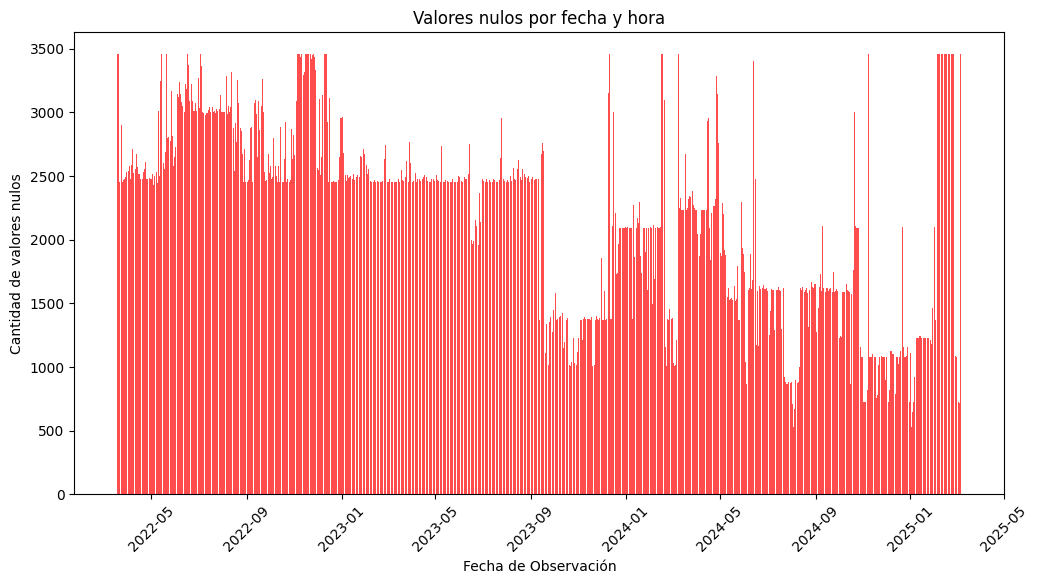

In [ ]:
# Lista de características a revisar
columnas_a_revisar = ['Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad']

# Contar valores nulos por fecha
df_nulos = df_consolidado_h[['FechaObservacion'] + columnas_a_revisar]
nulos_por_fecha = df_nulos.set_index('FechaObservacion').isnull().sum(axis=1)

# Agrupar por día para que sea más claro
nulos_por_fecha = nulos_por_fecha.resample('D').sum()

# Graficar en barras
plt.figure(figsize=(12, 6))
plt.bar(nulos_por_fecha.index, nulos_por_fecha, color='red', alpha=0.7)
plt.xlabel('Fecha de Observación')
plt.ylabel('Cantidad de valores nulos')
plt.title('Valores nulos por fecha y hora')
plt.xticks(rotation=45)
plt.show()

Cantidad de nulos por característica en porcentaje

In [ ]:
val_nulo_columna = df_consolidado_h.isna().sum()
print('Valores nulos por columna')
print((val_nulo_columna/df_consolidado_h.shape[0])*100)

Valores nulos por columna
CodigoEstacion       0.000000
Latitud              0.000000
Longitud             0.000000
FechaObservacion     0.000000
Direccion           52.317317
Humedad             76.979358
Precipitacion       47.679169
Presion             77.048835
Temperatura         77.226918
Velocidad           46.929303
dtype: float64


Aplicamos interpolación para completar valores nulos

In [ ]:
#Ordeno el dataset
df_consolidado_h = df_consolidado_h.sort_values(by=['CodigoEstacion', 'FechaObservacion'])
#Realizo interpolación
df_consolidado_h=df_consolidado_h.interpolate()
val_nulo_columna = df_consolidado_h.isna().sum()
print('Valores nulos por columna')
print(val_nulo_columna)
val_nulo = df_consolidado_h.isna().sum().sum()
print('Total valores nulos: ' ,val_nulo)

Valores nulos por columna
CodigoEstacion          0
Latitud                 0
Longitud                0
FechaObservacion        0
Direccion           65329
Humedad             65322
Precipitacion       65376
Presion             65376
Temperatura         65376
Velocidad           65329
dtype: int64
Total valores nulos:  392108


Cantidad de nulos por característica despues de aplicar interpolación

In [ ]:
val_nulo_columna = df_consolidado_h.isna().sum()
print('Valores nulos por columna')
print((val_nulo_columna/df_consolidado_h.shape[0])*100)

Valores nulos por columna
CodigoEstacion       0.000000
Latitud              0.000000
Longitud             0.000000
FechaObservacion     0.000000
Direccion           10.434076
Humedad             10.432958
Precipitacion       10.441582
Presion             10.441582
Temperatura         10.441582
Velocidad           10.434076
dtype: float64


In [ ]:
(val_nulo_columna/df_consolidado_h.shape[0])*100

,0
CodigoEstacion,0.000000
Latitud,0.000000
Longitud,0.000000
FechaObservacion,0.000000
Direccion,10.434076
Humedad,10.432958
Precipitacion,10.441582
Presion,10.441582
Temperatura,10.441582
Velocidad,10.434076


Revisamos como quedo el dataset despues de completar valores nulos

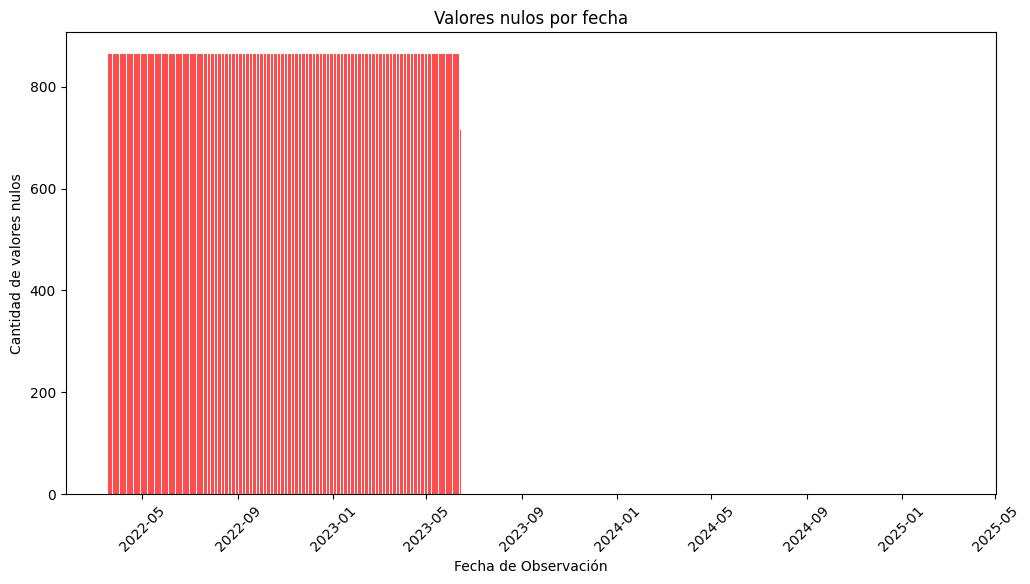

In [ ]:
# Lista de características a revisar
columnas_a_revisar = ['Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad']

# Contar valores nulos por fecha
df_nulos = df_consolidado_h[['FechaObservacion'] + columnas_a_revisar]
nulos_por_fecha = df_nulos.set_index('FechaObservacion').isnull().sum(axis=1)

# Agrupar por día
nulos_por_fecha = nulos_por_fecha.resample('D').sum()

# Graficar en barras
plt.figure(figsize=(12, 6))
plt.bar(nulos_por_fecha.index, nulos_por_fecha, color='red', alpha=0.7)
plt.xlabel("Fecha de Observación")
plt.ylabel("Cantidad de valores nulos")
plt.title("Valores nulos por fecha")
plt.xticks(rotation=45)
plt.show()

Como los datos faltantes están al inicio de la serie temporal aplicamos backward fill completando los primeros datos y le incluimos forward fill para posibles futuros dataset

In [ ]:
df_consolidado_h = df_consolidado_h.bfill()
df_consolidado_h = df_consolidado_h.ffill()

Volvemos a revisar

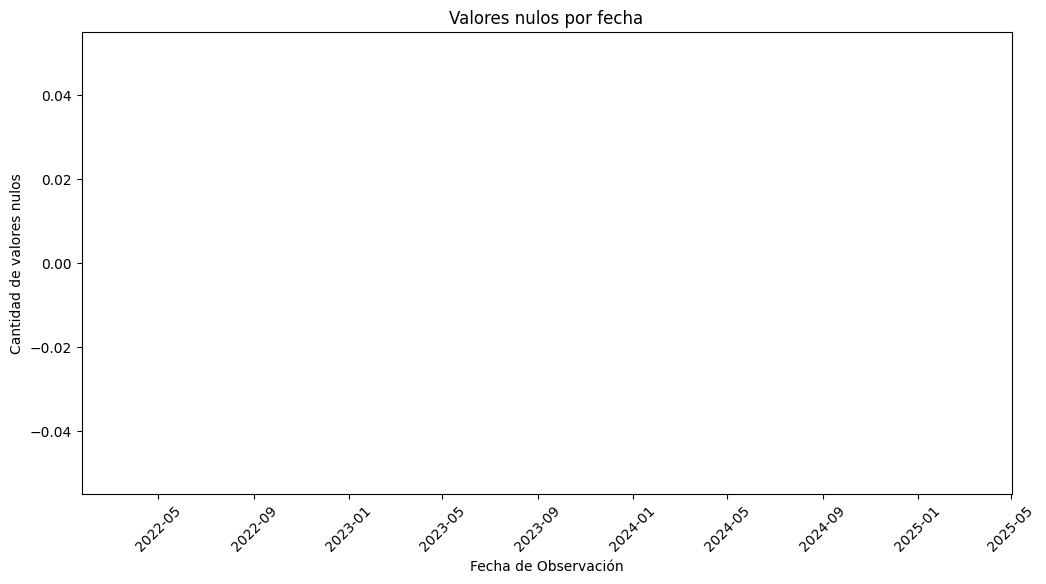

In [ ]:
# Lista de características a revisar
columnas_a_revisar = ['Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad']

# Contar valores nulos por fecha
df_nulos = df_consolidado_h[['FechaObservacion'] + columnas_a_revisar]
nulos_por_fecha = df_nulos.set_index('FechaObservacion').isnull().sum(axis=1)

# Agrupar por día
nulos_por_fecha = nulos_por_fecha.resample('D').sum()

# Graficar en barras
plt.figure(figsize=(12, 6))
plt.bar(nulos_por_fecha.index, nulos_por_fecha, color='red', alpha=0.7)
plt.xlabel("Fecha de Observación")
plt.ylabel("Cantidad de valores nulos")
plt.title("Valores nulos por fecha")
plt.xticks(rotation=45)
plt.show()

Completitud de los valores nulos

### **Características del conjunto de datos y tratamiento de outliers**

Copia del dataset

In [ ]:
df_consolidado_c = df_consolidado_h[['CodigoEstacion','Latitud','Longitud','FechaObservacion','Direccion','Humedad','Precipitacion','Presion','Temperatura','Velocidad']].copy()
df_consolidado_c = df_consolidado_c.reset_index(drop=True)
print('\nPrimeras filas\n')
print(df_consolidado_c.head())
print('\nÚltimas filas\n')
print(df_consolidado_c.tail())


Primeras filas

   CodigoEstacion    Latitud   Longitud    FechaObservacion  Direccion  \
0        14015010  10.794167 -75.260556 2022-03-18 00:00:00       38.0   
1        14015010  10.794167 -75.260556 2022-03-18 00:10:00       38.0   
2        14015010  10.794167 -75.260556 2022-03-18 00:20:00       38.0   
3        14015010  10.794167 -75.260556 2022-03-18 00:30:00       38.0   
4        14015010  10.794167 -75.260556 2022-03-18 00:40:00       38.0   

   Humedad  Precipitacion  Presion  Temperatura  Velocidad  
0     76.0            0.0   1007.4         29.0        4.1  
1     76.0            0.0   1007.4         29.0        4.1  
2     76.0            0.0   1007.4         29.0        4.1  
3     76.0            0.0   1007.4         29.0        4.1  
4     76.0            0.0   1007.4         29.0        4.1  

Últimas filas

        CodigoEstacion  Latitud  Longitud    FechaObservacion  Direccion  \
626107        29045190   10.918    -74.78 2025-03-08 23:10:00        6.0   
6261

Características generales

In [ ]:
c = ['Direccion','Humedad','Precipitacion','Presion','Temperatura','Velocidad']
print('\n\nDescripción de las características del dataset\n')
print(df_consolidado_c[c].describe())



Descripción de las características del dataset

           Direccion        Humedad  Precipitacion        Presion  \
count  626112.000000  626112.000000  626112.000000  626112.000000   
mean      103.341616      78.209960       0.018706    1008.492175   
std        85.407830      23.963849       0.266377       1.964439   
min         0.000000       0.000000       0.000000     968.200000   
25%        38.000000      76.000000       0.000000    1007.400000   
50%        76.648333      85.000000       0.000000    1008.300000   
75%       149.250122      93.876952       0.000000    1010.000000   
max       360.000000     100.000000      24.540000    1016.500000   

         Temperatura      Velocidad  
count  626112.000000  626112.000000  
mean       28.339390       3.214781  
std         3.396638       1.613675  
min         0.000000       0.000000  
25%        27.058097       2.016856  
50%        28.850500       3.000000  
75%        29.600000       4.100000  
max        41.600000    

Dimensión del dataset

In [ ]:
df_consolidado_c.shape

(626112, 10)

Ordenamos el dataset en caso de aplicar algún calculo lineal respecto a la fecha.

In [ ]:
df_consolidado_c = df_consolidado_c.sort_values(by=['CodigoEstacion', 'FechaObservacion'])

**Dirección del viento**

Distribución

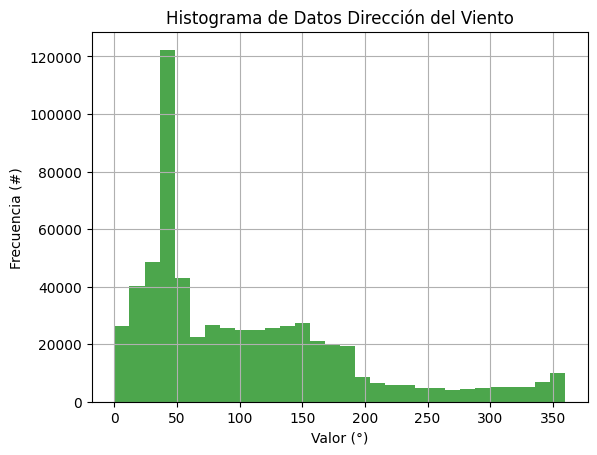

In [ ]:
plt.hist(df_consolidado_c['Direccion'], bins=30, color='green', alpha=0.7)
plt.title('Histograma de Datos Dirección del Viento')
plt.xlabel('Valor (°)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Direccion'].describe())

count    626112.000000
mean        103.341616
std          85.407830
min           0.000000
25%          38.000000
50%          76.648333
75%         149.250122
max         360.000000
Name: Direccion, dtype: float64


La dirección del viento esta dentro del rango de 0° a 365°, se observa que la mayor frecuencia tiene la dirección de menos de 50°

Indentificar los outliers de la dirección del viento utilizando medidas circulares

In [ ]:
# Se extraen las componentes en x y y de la dirección
df_consolidado_c['wind_x'] = np.cos(np.radians(df_consolidado_c['Direccion']))
df_consolidado_c['wind_y'] = np.sin(np.radians(df_consolidado_c['Direccion']))

# Calcular la media de las componentes X e Y
mean_x = np.mean(df_consolidado_c['wind_x'])
mean_y = np.mean(df_consolidado_c['wind_y'])

# Convertir de nuevo a grados
media_circular_manual = np.degrees(np.arctan2(mean_y, mean_x))

# Asegurar que esté en el rango [0, 360]
if media_circular_manual < 0:
    media_circular_manual += 360

# Calcular la diferencia angular respecto a la media circular
df_consolidado_c['angular_diff'] = np.abs((df_consolidado_c['Direccion'] - media_circular_manual + 180) % 360 - 180)

# Definir del umbral de outliers
umbral_outlier = df_consolidado_c['angular_diff'].mean() + 3 * df_consolidado_c['angular_diff'].std()

# Identificar outliers
outliers = df_consolidado_c[df_consolidado_c['angular_diff'] > umbral_outlier]
print('Media: ',media_circular_manual)
print('Cantidad de outliers: ',len(outliers))
print('Porcentaje de outliers: ', (len(outliers)/df_consolidado_c.shape[0])*100)

c = ['FechaObservacion','Direccion']

print('Umbral: ', umbral_outlier)
# Imprime los outliers
print('Outliers:')
print(outliers[c])

Media:  67.71750724834064
Cantidad de outliers:  1247
Porcentaje de outliers:  0.1991656444853317
Umbral:  178.47808470490975
Outliers:
          FechaObservacion   Direccion
67033  2023-06-26 12:10:00  247.000000
67039  2023-06-26 13:10:00  249.000000
67168  2023-06-27 10:40:00  247.000000
116491 2024-06-03 23:10:00  248.000000
116629 2024-06-04 22:10:00  249.000000
...                    ...         ...
616335 2024-12-31 02:30:00  247.000000
616365 2024-12-31 07:30:00  247.000000
617255 2025-01-06 11:50:00  248.000000
625793 2025-03-06 18:50:00  247.986207
626039 2025-03-08 11:50:00  248.000000

[1247 rows x 2 columns]


Los outliers se reemplazarán con la mediana

In [ ]:
# Calculo de la mediana de los valores sin outliers
df_mediana = df_consolidado_c[df_consolidado_c['Direccion'] <= umbral_outlier]
mediana_x = np.median(df_mediana['wind_x'])
mediana_y = np.median(df_mediana['wind_y'])
mediana_circular = np.degrees(np.arctan2(mediana_y, mediana_x))
if mediana_circular < 0:
    mediana_circular += 360

print('Mediana circular: ',mediana_circular)

df_consolidado_c.loc[df_consolidado_c['Direccion'] > umbral_outlier, 'Direccion'] = mediana_circular

Mediana circular:  45.95737105866925


Validar que ya no existan outliers

In [ ]:
print(df_consolidado_c[df_consolidado_c['Direccion'] > umbral_outlier])

Empty DataFrame
Columns: [CodigoEstacion, Latitud, Longitud, FechaObservacion, Direccion, Humedad, Precipitacion, Presion, Temperatura, Velocidad, wind_x, wind_y, angular_diff]
Index: []


Descripción

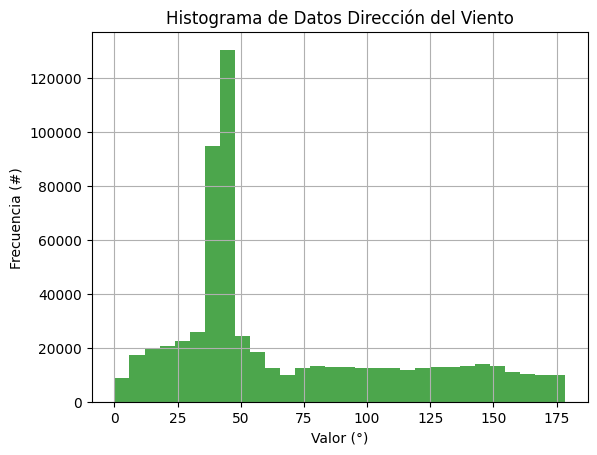

In [ ]:
plt.hist(df_consolidado_c['Direccion'], bins=30, color='green', alpha=0.7)
plt.title('Histograma de Datos Dirección del Viento')
plt.xlabel('Valor (°)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print('\n\nDescripción\n')
print(df_consolidado_c['Direccion'].describe())



Descripción

count    626112.000000
mean         68.428333
std          45.702006
min           0.000000
25%          38.000000
50%          45.957371
75%         101.230693
max         178.477310
Name: Direccion, dtype: float64


**Humedad**

Distribución

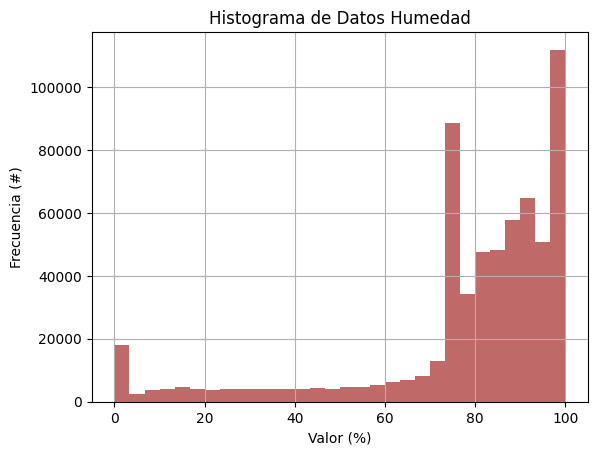

In [ ]:
plt.hist(df_consolidado_c['Humedad'], bins=30, color='brown', alpha=0.7)
plt.title('Histograma de Datos Humedad')
plt.xlabel('Valor (%)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Humedad'].describe())

count    626112.000000
mean         78.209960
std          23.963849
min           0.000000
25%          76.000000
50%          85.000000
75%          93.876952
max         100.000000
Name: Humedad, dtype: float64


La humedad esta medida en porcentaje y esta dentro del rango del 0% y el 100%, la distribución muestra que la humedad tiende al 100%. Sesgo a la izquierda.

In [ ]:
# Calcula los cuartiles
Q1 = np.percentile(df_consolidado_c['Humedad'], 25)
Q3 = np.percentile(df_consolidado_c['Humedad'], 75)

c = ['FechaObservacion','Humedad']

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites
# Duplico la constante para calcular los limites debido a que es una distribución asimétrica
limite_inferior = Q1 - 3.5 * IQR # Cubrir alrededor del 95% de los datos
#El limite máximo es 100%
limite_superior = 100

print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Humedad'] < limite_inferior) | (df_consolidado_c['Humedad'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  13.430668435103215
Limite superior:  100
Cantidad de outliers:  28646
Porcentaje de outliers:  4.575219768987019
Outliers:
          FechaObservacion    Humedad
110531 2024-04-23 13:50:00  13.429895
110532 2024-04-23 14:00:00  13.428466
110533 2024-04-23 14:10:00  13.427037
110534 2024-04-23 14:20:00  13.425608
110535 2024-04-23 14:30:00  13.424179
...                    ...        ...
624875 2025-02-28 09:50:00   0.000000
626091 2025-03-08 20:30:00   0.000000
626105 2025-03-08 22:50:00   0.000000
626107 2025-03-08 23:10:00   0.000000
626108 2025-03-08 23:20:00   7.500000

[28646 rows x 2 columns]


Gráficamente se observa

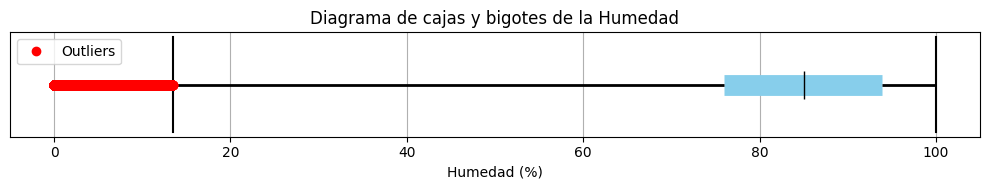

In [ ]:
# Datos
data = df_consolidado_c['Humedad'].dropna()
median = np.median(data)

# Separar outliers
outliers = data[(data < limite_inferior) | (data > limite_superior)]
box_data = data[(data >= limite_inferior) & (data <= limite_superior)]

# Coordenadas horizontales para la caja
box_x = [Q1, Q3]
whiskers_x = [limite_inferior, Q1, Q3, limite_superior]

plt.figure(figsize=(10, 2))

# Dibujar caja
plt.hlines(y=1, xmin=Q1, xmax=Q3, color='skyblue', linewidth=15)

# Mediana
plt.plot(median, 1, 'k|', markersize=20)

# Bigotes
plt.hlines(y=1, xmin=limite_inferior, xmax=Q1, color='black', linewidth=2)
plt.hlines(y=1, xmin=Q3, xmax=limite_superior, color='black', linewidth=2)
plt.plot([limite_inferior, limite_inferior], [0.95, 1.05], color='black')
plt.plot([limite_superior, limite_superior], [0.95, 1.05], color='black')

# Outliers
plt.plot(outliers, np.ones_like(outliers), 'ro', label='Outliers')

# Ajustes visuales
plt.yticks([])
plt.xlabel('Humedad (%)')
plt.title('Diagrama de cajas y bigotes de la Humedad')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()

Selección de los outliers

In [ ]:
c = ['FechaObservacion','Humedad']
outliers = df_consolidado_c[(df_consolidado_c['Humedad'] < limite_inferior) | (df_consolidado_c['Humedad'] > limite_superior)]
print(f"Cantidad de outliers detectados: {len(outliers)}")
print(outliers[c].head())

Cantidad de outliers detectados: 28646
          FechaObservacion    Humedad
110531 2024-04-23 13:50:00  13.429895
110532 2024-04-23 14:00:00  13.428466
110533 2024-04-23 14:10:00  13.427037
110534 2024-04-23 14:20:00  13.425608
110535 2024-04-23 14:30:00  13.424179


Los outliers se reemplazarán con la mediana

In [ ]:
# Filtrar solo los valores dentro del rango permitido
valores_dentro_rango = df_consolidado_c[(df_consolidado_c['Humedad'] >= limite_inferior) & (df_consolidado_c['Humedad'] <= limite_superior)]['Humedad']

# Calcular la mediana de estos valores filtrados
mediana_rango = valores_dentro_rango.median()

# Reemplazar outliers con la mediana de los valores dentro del rango
df_consolidado_c.loc[df_consolidado_c['Humedad'] > limite_superior, 'Humedad'] = mediana_rango
df_consolidado_c.loc[df_consolidado_c['Humedad'] < limite_inferior, 'Humedad'] = mediana_rango

Validar que ya no existan los outliers

In [ ]:
print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Humedad'] < limite_inferior) | (df_consolidado_c['Humedad'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  13.430668435103215
Limite superior:  100
Cantidad de outliers:  0
Porcentaje de outliers:  0.0
Outliers:
Empty DataFrame
Columns: [FechaObservacion, Humedad]
Index: []


Descripción

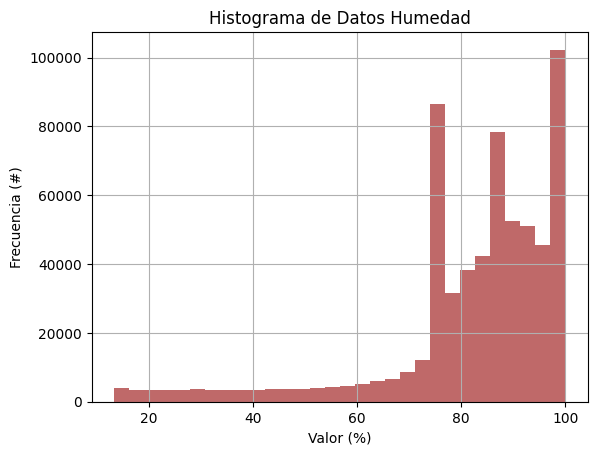

In [ ]:
plt.hist(df_consolidado_c['Humedad'], bins=30, color='brown', alpha=0.7)
plt.title('Histograma de Datos Humedad')
plt.xlabel('Valor (%)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print('\n\nDescripción\n')
print(df_consolidado_c['Humedad'].describe())



Descripción

count    626112.000000
mean         81.981689
std          17.482578
min          13.431325
25%          76.000000
50%          85.833333
75%          93.876952
max         100.000000
Name: Humedad, dtype: float64


**Precipitación**

Distribución

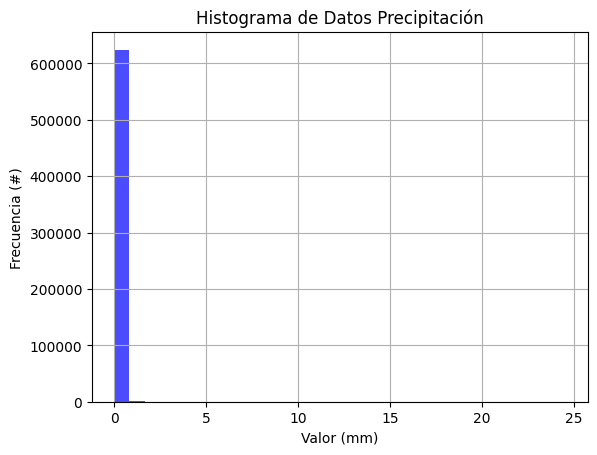

In [ ]:
plt.hist(df_consolidado_c['Precipitacion'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Datos Precipitación')
plt.xlabel('Valor (mm)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Precipitacion'].describe())

count    626112.000000
mean          0.018706
std           0.266377
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.540000
Name: Precipitacion, dtype: float64


Se observa muy poca precipitación por lo cual se deja la variable sin modificaciones

**Presión atmosférica**

Distribución

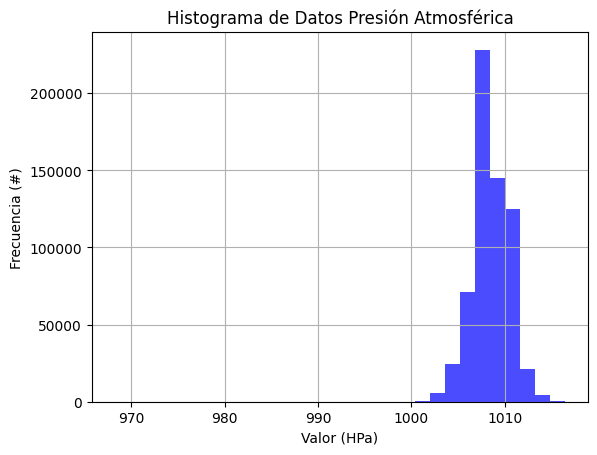

In [ ]:
plt.hist(df_consolidado_c['Presion'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Datos Presión Atmosférica')
plt.xlabel('Valor (HPa)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Presion'].describe())

count    626112.000000
mean       1008.492175
std           1.964439
min         968.200000
25%        1007.400000
50%        1008.300000
75%        1010.000000
max        1016.500000
Name: Presion, dtype: float64


Tiene una distribución simétrica, centrada a los 1000 HPa aproximadamente.

Identificamos outliers

In [ ]:
# Calcula los cuartiles
Q1 = np.percentile(df_consolidado_c['Presion'], 25)
Q3 = np.percentile(df_consolidado_c['Presion'], 75)

c = ['FechaObservacion','Presion']

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Presion'] < limite_inferior) | (df_consolidado_c['Presion'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  1003.5
Limite superior:  1013.9000000000001
Cantidad de outliers:  7064
Porcentaje de outliers:  1.128232648471839
Outliers:
          FechaObservacion      Presion
128498 2024-08-26 08:20:00  1013.933333
128499 2024-08-26 08:30:00  1014.100000
128500 2024-08-26 08:40:00  1014.266667
128501 2024-08-26 08:50:00  1014.433333
128502 2024-08-26 09:00:00  1014.600000
...                    ...          ...
625672 2025-03-05 22:40:00  1003.300000
625673 2025-03-05 22:50:00  1002.100000
625674 2025-03-05 23:00:00  1002.100000
625675 2025-03-05 23:10:00  1002.400000
625676 2025-03-05 23:20:00  1002.200000

[7064 rows x 2 columns]


Gráficamente se observa

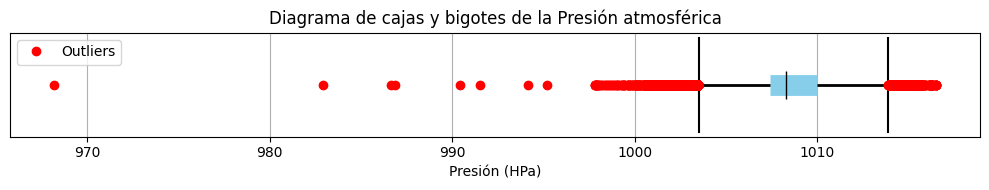

In [ ]:
# Datos
data = df_consolidado_c['Presion'].dropna()
median = np.median(data)

# Separar outliers
outliers = data[(data < limite_inferior) | (data > limite_superior)]
box_data = data[(data >= limite_inferior) & (data <= limite_superior)]

# Coordenadas horizontales para la caja
box_x = [Q1, Q3]
whiskers_x = [limite_inferior, Q1, Q3, limite_superior]

plt.figure(figsize=(10, 2))

# Dibujar caja
plt.hlines(y=1, xmin=Q1, xmax=Q3, color='skyblue', linewidth=15)

# Mediana
plt.plot(median, 1, 'k|', markersize=20)

# Bigotes
plt.hlines(y=1, xmin=limite_inferior, xmax=Q1, color='black', linewidth=2)
plt.hlines(y=1, xmin=Q3, xmax=limite_superior, color='black', linewidth=2)
plt.plot([limite_inferior, limite_inferior], [0.95, 1.05], color='black')
plt.plot([limite_superior, limite_superior], [0.95, 1.05], color='black')

# Outliers
plt.plot(outliers, np.ones_like(outliers), 'ro', label='Outliers')

# Ajustes visuales
plt.yticks([])
plt.xlabel('Presión (HPa)')
plt.title('Diagrama de cajas y bigotes de la Presión atmosférica')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()

Se reemplaza los outliers mediante interpolación

In [ ]:
df_consolidado_c.loc[(df_consolidado_c['Presion'] < limite_inferior) | (df_consolidado_c['Presion'] > limite_superior), 'Presion'] = np.nan
df_consolidado_c['Presion'] = df_consolidado_c['Presion'].interpolate(method='linear')

Validación de la modificación

In [ ]:
print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Presion'] < limite_inferior) | (df_consolidado_c['Presion'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  1003.5
Limite superior:  1013.9000000000001
Cantidad de outliers:  0
Porcentaje de outliers:  0.0
Outliers:
Empty DataFrame
Columns: [FechaObservacion, Presion]
Index: []


Descripción

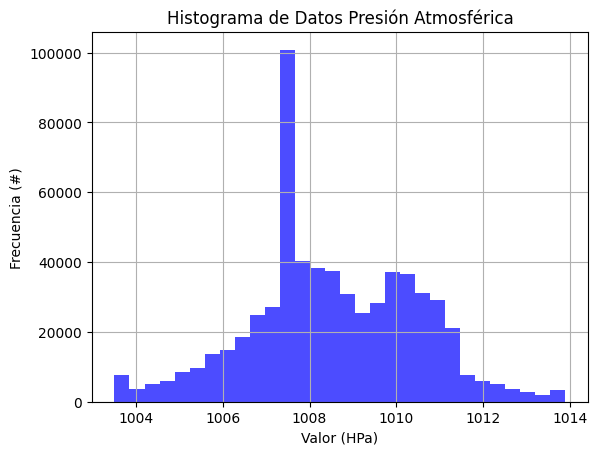

In [ ]:
plt.hist(df_consolidado_c['Presion'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma de Datos Presión Atmosférica')
plt.xlabel('Valor (HPa)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print('\n\nDescripción\n')
print(df_consolidado_c['Presion'].describe())



Descripción

count    626112.000000
mean       1008.498080
std           1.934256
min        1003.500000
25%        1007.400000
50%        1008.300000
75%        1010.000000
max        1013.900000
Name: Presion, dtype: float64


**Temperatura**

Distribución

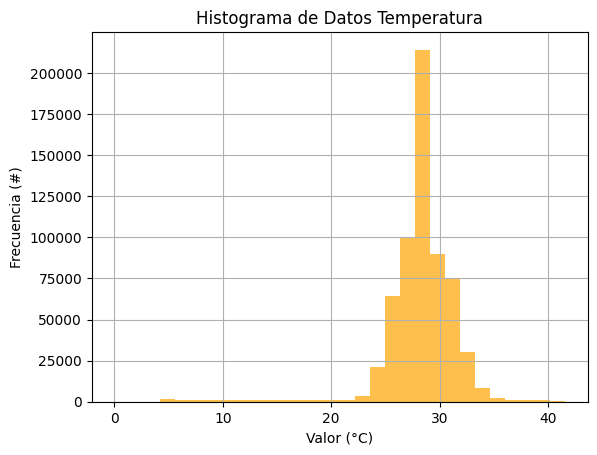

In [ ]:
plt.hist(df_consolidado_h['Temperatura'], bins=30, color='orange', alpha=0.7)
plt.title('Histograma de Datos Temperatura')
plt.xlabel('Valor (°C)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Temperatura'].describe())

count    626112.000000
mean         28.339390
std           3.396638
min           0.000000
25%          27.058097
50%          28.850500
75%          29.600000
max          41.600000
Name: Temperatura, dtype: float64


Tiene una distribución simétrica con sesgo a la izquierda. Aumento la constante del limmite inferior para lograr cubrir el 95% de los datos originales.

Identificamos outliers

In [ ]:
# Calcula los cuartiles
Q1 = np.percentile(df_consolidado_c['Temperatura'], 25)
Q3 = np.percentile(df_consolidado_c['Temperatura'], 75)

c = ['FechaObservacion','Temperatura']

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites
limite_inferior = Q1 - 1.5 * IQR # Aumento este valor para poder cubrir alrededor del 95%
limite_superior = Q3 + 1.5 * IQR

print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Temperatura'] < limite_inferior) | (df_consolidado_c['Temperatura'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  23.245241454902796
Limite superior:  33.41285512705832
Cantidad de outliers:  29956
Porcentaje de outliers:  4.78444751098845
Outliers:
          FechaObservacion  Temperatura
66596  2023-06-23 11:20:00    33.633333
66597  2023-06-23 11:30:00    34.000000
66598  2023-06-23 11:40:00    34.366667
66599  2023-06-23 11:50:00    34.733333
66600  2023-06-23 12:00:00    35.100000
...                    ...          ...
626071 2025-03-08 17:10:00    34.200000
626072 2025-03-08 17:20:00    34.400000
626073 2025-03-08 17:30:00    34.400000
626074 2025-03-08 17:40:00    34.000000
626075 2025-03-08 17:50:00    33.500000

[29956 rows x 2 columns]


Gráficamente se observa

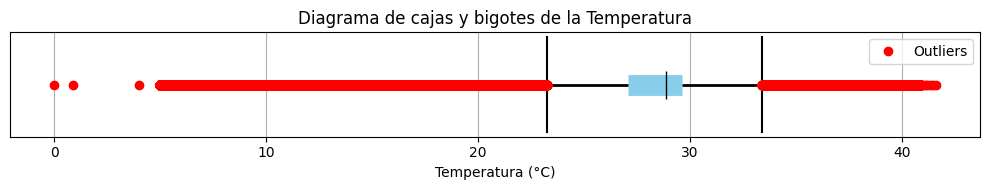

In [ ]:
# Datos
data = df_consolidado_c['Temperatura'].dropna()
median = np.median(data)

# Separar outliers
outliers = data[(data < limite_inferior) | (data > limite_superior)]
box_data = data[(data >= limite_inferior) & (data <= limite_superior)]

# Coordenadas horizontales para la caja
box_x = [Q1, Q3]
whiskers_x = [limite_inferior, Q1, Q3, limite_superior]

plt.figure(figsize=(10, 2))

# Dibujar caja
plt.hlines(y=1, xmin=Q1, xmax=Q3, color='skyblue', linewidth=15)

# Mediana
plt.plot(median, 1, 'k|', markersize=20)

# Bigotes
plt.hlines(y=1, xmin=limite_inferior, xmax=Q1, color='black', linewidth=2)
plt.hlines(y=1, xmin=Q3, xmax=limite_superior, color='black', linewidth=2)
plt.plot([limite_inferior, limite_inferior], [0.95, 1.05], color='black')
plt.plot([limite_superior, limite_superior], [0.95, 1.05], color='black')

# Outliers
plt.plot(outliers, np.ones_like(outliers), 'ro', label='Outliers')

# Ajustes visuales
plt.yticks([])
plt.xlabel('Temperatura (°C)')
plt.title('Diagrama de cajas y bigotes de la Temperatura')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()

Se reemplaza los outliers mediante interpolación

In [ ]:
df_consolidado_c.loc[(df_consolidado_c['Temperatura'] < limite_inferior) | (df_consolidado_c['Temperatura'] > limite_superior), 'Temperatura'] = np.nan
df_consolidado_c['Temperatura'] = df_consolidado_c['Temperatura'].interpolate(method='linear')

Validación de la modificación

In [ ]:
print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Temperatura'] < limite_inferior) | (df_consolidado_c['Temperatura'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  23.245241454902796
Limite superior:  33.41285512705832
Cantidad de outliers:  0
Porcentaje de outliers:  0.0
Outliers:
Empty DataFrame
Columns: [FechaObservacion, Temperatura]
Index: []


Descripción

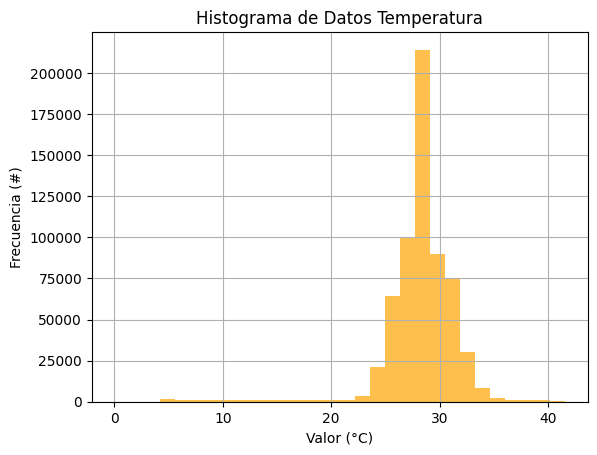

In [ ]:
plt.hist(df_consolidado_h['Temperatura'], bins=30, color='orange', alpha=0.7)
plt.title('Histograma de Datos Temperatura')
plt.xlabel('Valor (°C)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print('\n\nDescripción\n')
print(df_consolidado_c['Temperatura'].describe())



Descripción

count    626112.000000
mean         28.551720
std           2.223500
min          23.246426
25%          27.058320
50%          28.850500
75%          29.600000
max          33.412628
Name: Temperatura, dtype: float64


**Velocidad del viento**

Distribución

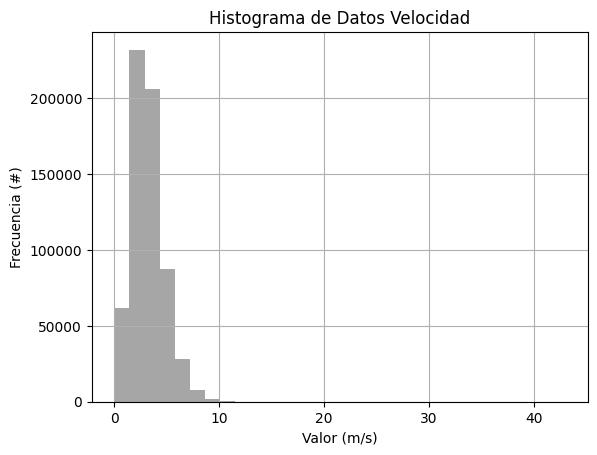

In [ ]:
plt.hist(df_consolidado_c['Velocidad'], bins=30, color='gray', alpha=0.7)
plt.title('Histograma de Datos Velocidad')
plt.xlabel('Valor (m/s)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print(df_consolidado_c['Velocidad'].describe())

count    626112.000000
mean          3.214781
std           1.613675
min           0.000000
25%           2.016856
50%           3.000000
75%           4.100000
max          43.000000
Name: Velocidad, dtype: float64


Tiene una distribución simétrica. El límite inferior se deja con el valor cero (0).

Identificación de outliers

In [ ]:
# Calcula los cuartiles
Q1 = np.percentile(df_consolidado_c['Velocidad'], 25)
Q3 = np.percentile(df_consolidado_c['Velocidad'], 75)

c = ['FechaObservacion','Velocidad']

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites
limite_inferior = 0
limite_superior = Q3 + 1.5 * IQR

print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Velocidad'] < limite_inferior) | (df_consolidado_c['Velocidad'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  0
Limite superior:  7.224716423820081
Cantidad de outliers:  9519
Porcentaje de outliers:  1.520335019932536
Outliers:
          FechaObservacion  Velocidad
65384  2023-06-15 01:20:00      7.600
65387  2023-06-15 01:50:00      7.300
66405  2023-06-22 03:30:00      7.700
66408  2023-06-22 04:00:00      7.900
66409  2023-06-22 04:10:00      7.624
...                    ...        ...
625091 2025-03-01 21:50:00      7.350
625388 2025-03-03 23:20:00      7.500
625555 2025-03-05 03:10:00      7.450
625951 2025-03-07 21:10:00      8.000
625953 2025-03-07 21:30:00      7.450

[9519 rows x 2 columns]


Gráficamente se observa

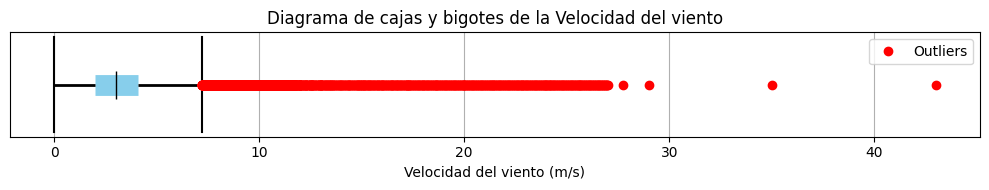

In [ ]:
# Datos
data = df_consolidado_c['Velocidad'].dropna()
median = np.median(data)

# Separar outliers
outliers = data[(data < limite_inferior) | (data > limite_superior)]
box_data = data[(data >= limite_inferior) & (data <= limite_superior)]

# Coordenadas horizontales para la caja
box_x = [Q1, Q3]
whiskers_x = [limite_inferior, Q1, Q3, limite_superior]

plt.figure(figsize=(10, 2))

# Dibujar caja
plt.hlines(y=1, xmin=Q1, xmax=Q3, color='skyblue', linewidth=15)

# Mediana
plt.plot(median, 1, 'k|', markersize=20)

# Bigotes
plt.hlines(y=1, xmin=limite_inferior, xmax=Q1, color='black', linewidth=2)
plt.hlines(y=1, xmin=Q3, xmax=limite_superior, color='black', linewidth=2)
plt.plot([limite_inferior, limite_inferior], [0.95, 1.05], color='black')
plt.plot([limite_superior, limite_superior], [0.95, 1.05], color='black')

# Outliers
plt.plot(outliers, np.ones_like(outliers), 'ro', label='Outliers')

# Ajustes visuales
plt.yticks([])
plt.xlabel('Velocidad del viento (m/s)')
plt.title('Diagrama de cajas y bigotes de la Velocidad del viento')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()

Se reemplaza los outliers mediante interpolación

In [ ]:
df_consolidado_c.loc[(df_consolidado_c['Velocidad'] < limite_inferior) | (df_consolidado_c['Velocidad'] > limite_superior), 'Velocidad'] = np.nan
df_consolidado_c['Velocidad'] = df_consolidado_c['Velocidad'].interpolate(method='linear')

Validación de la modificación

In [ ]:
print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Velocidad'] < limite_inferior) | (df_consolidado_c['Velocidad'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  0
Limite superior:  7.224716423820081
Cantidad de outliers:  0
Porcentaje de outliers:  0.0
Outliers:
Empty DataFrame
Columns: [FechaObservacion, Velocidad]
Index: []


Descripción

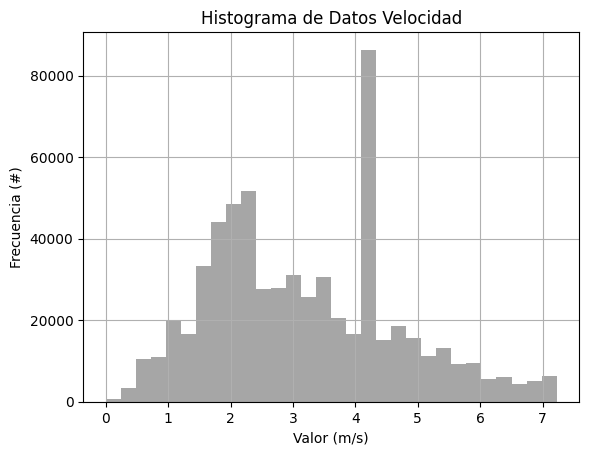

In [ ]:
plt.hist(df_consolidado_c['Velocidad'], bins=30, color='gray', alpha=0.7)
plt.title('Histograma de Datos Velocidad')
plt.xlabel('Valor (m/s)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

In [ ]:
print('\n\nDescripción\n')
print(df_consolidado_c['Velocidad'].describe())



Descripción

count    626112.000000
mean          3.183031
std           1.481700
min           0.000000
25%           2.016850
50%           3.000000
75%           4.100000
max           7.224132
Name: Velocidad, dtype: float64


In [ ]:
df_consolidado_c = df_consolidado_c[['CodigoEstacion','Latitud','Longitud','FechaObservacion','Direccion','Humedad','Precipitacion','Presion','Temperatura','Velocidad']]
print(df_consolidado_c.columns)

Index(['CodigoEstacion', 'Latitud', 'Longitud', 'FechaObservacion',
       'Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura',
       'Velocidad'],
      dtype='object')


### **Cálculo de la potencia del viento**

Incluyo la variable calculada de la potencia del viento

P = 1/2 * p * A * V^3

P = Potencia del viento (vatios o W) p = Densidad del aire (kg/m^3) A = Área barrida por la palas (A = pi * r^2) (m^2) v = Velocidad del viento (m/s)

Nota: Las palas utilizas en las turbinas colombianas tiene una logitud de 50 m

Y la formula de densidad es

p = P / R * T

p = Densidad del aire (kg/m^3) P = Presión atmosférica (Pascales o Pa) R = Constante específica del aire seco (287.05) T = Temperatura absoluta (Kelvin o K)

Creación de la característica potencia eólica

In [ ]:
df_consolidado_c['Potencia'] = np.where(
    df_consolidado_c['Presion'].notna() & df_consolidado_c['Temperatura'].notna() & df_consolidado_c['Velocidad'].notna(),
    round((1/2 * ((df_consolidado_c['Presion'] * 100) / (287.05 * (df_consolidado_c['Temperatura'] + 273.15))) * ((50 ** 2) * np.pi) * (df_consolidado_c['Velocidad'] ** 3))),
    np.nan
)
df_consolidado_c = df_consolidado_c.sort_values(by=['CodigoEstacion', 'FechaObservacion'])
print('\nPrimeras filas\n')
print(df_consolidado_c.head())
print('\nÚltimas filas\n')
print(df_consolidado_c.tail())


Primeras filas

   CodigoEstacion    Latitud   Longitud    FechaObservacion  Direccion  \
0        14015010  10.794167 -75.260556 2022-03-18 00:00:00       38.0   
1        14015010  10.794167 -75.260556 2022-03-18 00:10:00       38.0   
2        14015010  10.794167 -75.260556 2022-03-18 00:20:00       38.0   
3        14015010  10.794167 -75.260556 2022-03-18 00:30:00       38.0   
4        14015010  10.794167 -75.260556 2022-03-18 00:40:00       38.0   

   Humedad  Precipitacion  Presion  Temperatura  Velocidad  Potencia  
0     76.0            0.0   1007.4         29.0        4.1  314364.0  
1     76.0            0.0   1007.4         29.0        4.1  314364.0  
2     76.0            0.0   1007.4         29.0        4.1  314364.0  
3     76.0            0.0   1007.4         29.0        4.1  314364.0  
4     76.0            0.0   1007.4         29.0        4.1  314364.0  

Últimas filas

        CodigoEstacion  Latitud  Longitud    FechaObservacion  Direccion  \
626107        290451

In [ ]:
print(df_consolidado_c.shape)

(626112, 11)


Complemento de valores nulos

In [ ]:
df_consolidado_c = df_consolidado_c.sort_values(by=['CodigoEstacion', 'FechaObservacion'])
df_consolidado_c['Potencia'] = df_consolidado_c['Potencia'].interpolate(method='linear')

**Distribución de la potencia eólica**

In [ ]:
potencia_kw = df_consolidado_c['Potencia'] / 1000
print('Descripción de la potencia en KW\n')
print(potencia_kw.describe())

Descripción de la potencia en KW

count    626112.000000
mean        250.053794
std         319.729032
min           0.000000
25%          37.549750
50%         124.262000
75%         314.364000
max        1740.381000
Name: Potencia, dtype: float64


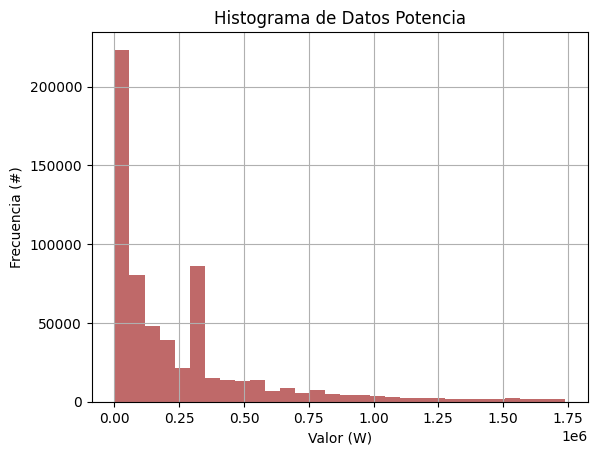

In [ ]:
potencia_kw = df_consolidado_c['Potencia']
plt.hist(potencia_kw, bins=30, color='brown', alpha=0.7)
plt.title('Histograma de Datos Potencia')
plt.xlabel('Valor (W)')
plt.ylabel('Frecuencia (#)')
plt.grid(True)
plt.show()

Presenta una concentración entre los 0 y los 500 KW, sesgo derecho. Por lo anterior aumentamos la constante del limite superior siempre conservando el 95% de los datos originales. Además se deja el límite inferior en cero (0).

Cálculo de outliers

In [ ]:
# Calcula los cuartiles
Q1 = np.percentile(df_consolidado_c['Potencia'], 25)
Q3 = np.percentile(df_consolidado_c['Potencia'], 75)

c = ['FechaObservacion','Potencia']

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites
limite_inferior = 0
limite_superior = Q3 + 3 * IQR

print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Potencia'] < limite_inferior) | (df_consolidado_c['Potencia'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  0
Limite superior:  1144806.75
Cantidad de outliers:  20981
Porcentaje de outliers:  3.3509979045282634
Outliers:
          FechaObservacion   Potencia
65372  2023-06-14 23:20:00  1195698.0
65376  2023-06-15 00:00:00  1252627.0
65383  2023-06-15 01:10:00  1369060.0
65384  2023-06-15 01:20:00  1399778.0
65385  2023-06-15 01:30:00  1430949.0
...                    ...        ...
625955 2025-03-07 21:50:00  1146820.0
625964 2025-03-07 23:20:00  1182078.0
625992 2025-03-08 04:00:00  1214011.0
625994 2025-03-08 04:20:00  1556002.0
626096 2025-03-08 21:20:00  1162843.0

[20981 rows x 2 columns]


Visualización de los outliers

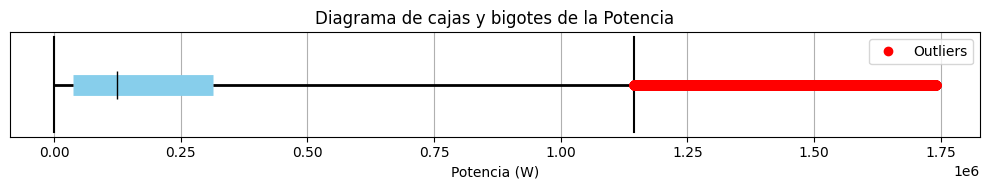

In [ ]:
# Datos
data = df_consolidado_c['Potencia'].dropna()
median = np.median(data)

# Separar outliers
outliers = data[(data < limite_inferior) | (data > limite_superior)]
box_data = data[(data >= limite_inferior) & (data <= limite_superior)]

# Coordenadas horizontales para la caja
box_x = [Q1, Q3]
whiskers_x = [limite_inferior, Q1, Q3, limite_superior]

plt.figure(figsize=(10, 2))

# Dibujar caja
plt.hlines(y=1, xmin=Q1, xmax=Q3, color='skyblue', linewidth=15)

# Mediana
plt.plot(median, 1, 'k|', markersize=20)

# Bigotes
plt.hlines(y=1, xmin=limite_inferior, xmax=Q1, color='black', linewidth=2)
plt.hlines(y=1, xmin=Q3, xmax=limite_superior, color='black', linewidth=2)
plt.plot([limite_inferior, limite_inferior], [0.95, 1.05], color='black')
plt.plot([limite_superior, limite_superior], [0.95, 1.05], color='black')

# Outliers
plt.plot(outliers, np.ones_like(outliers), 'ro', label='Outliers')

# Ajustes visuales
plt.yticks([])
plt.xlabel('Potencia (W)')
plt.title('Diagrama de cajas y bigotes de la Potencia')
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()

Se reemplaza outliers mediante interpolación

In [ ]:
df_consolidado_c.loc[(df_consolidado_c['Potencia'] < limite_inferior) | (df_consolidado_c['Potencia'] > limite_superior), 'Potencia'] = np.nan
df_consolidado_c['Potencia'] = df_consolidado_c['Potencia'].interpolate(method='linear')

Validación de la modificación

In [ ]:
# Límites
print('Limite inferior: ', limite_inferior)
print('Limite superior: ', limite_superior)

# Identifica outliers
outliers = (df_consolidado_c['Potencia'] < limite_inferior) | (df_consolidado_c['Potencia'] > limite_superior)

print('Cantidad de outliers: ', outliers.sum())
print('Porcentaje de outliers: ', (outliers.sum()/df_consolidado_c.shape[0])*100)

# Imprime los outliers
print('Outliers:')
print(df_consolidado_c[c][outliers])

Limite inferior:  0
Limite superior:  1144806.75
Cantidad de outliers:  0
Porcentaje de outliers:  0.0
Outliers:
Empty DataFrame
Columns: [FechaObservacion, Potencia]
Index: []


Características de la potencia

In [ ]:
potencia_kw = df_consolidado_c['Potencia'] / 1000
print(potencia_kw.describe())

count    626112.000000
mean        233.928118
std         267.170669
min           0.000000
25%          37.549000
50%         124.258000
75%         314.364000
max        1144.790000
Name: Potencia, dtype: float64


Validar la cantidad de ceros

In [ ]:
ceros = (df_consolidado_c['Potencia'] == 0).sum()
total = df_consolidado_c['Potencia'].shape[0]
porcentaje = ceros / total * 100

print(f"Cantidad de ceros: {ceros}")
print(f"Porcentaje: {porcentaje:.2f}%")

Cantidad de ceros: 78
Porcentaje: 0.01%


### **Selección de características temporales respecto al comportamiento de la potencia**

Creamos variables de tiempo con el fin de validar su comportamiento

In [ ]:
df_consolidado_h = df_consolidado_c.copy()
df_consolidado_h.loc[:, 'Anio'] = df_consolidado_h['FechaObservacion'].dt.year
df_consolidado_h.loc[:, 'Mes'] = df_consolidado_h['FechaObservacion'].dt.month
df_consolidado_h.loc[:, 'AnioMes'] = df_consolidado_h['FechaObservacion'].dt.to_period('M').astype(str)
df_consolidado_h.loc[:, 'Dia'] = df_consolidado_h['FechaObservacion'].dt.day
df_consolidado_h.loc[:, 'DiaSemana'] = df_consolidado_h['FechaObservacion'].dt.dayofweek
df_consolidado_h.loc[:, 'DiaDelAnio'] = df_consolidado_h['FechaObservacion'].dt.dayofyear
df_consolidado_h.loc[:, 'DiasDesdeInicio'] = (df_consolidado_h['FechaObservacion'] - df_consolidado_h['FechaObservacion'].min()).dt.days
df_consolidado_h.loc[:, 'Hora'] = df_consolidado_h['FechaObservacion'].dt.hour
df_consolidado_h.loc[:, 'Minuto'] = df_consolidado_h['FechaObservacion'].dt.minute
df_consolidado_h.loc[:, 'Segundo'] = df_consolidado_h['FechaObservacion'].dt.second

print(df_consolidado_h.head())

   CodigoEstacion    Latitud   Longitud    FechaObservacion  Direccion  \
0        14015010  10.794167 -75.260556 2022-03-18 00:00:00       38.0   
1        14015010  10.794167 -75.260556 2022-03-18 00:10:00       38.0   
2        14015010  10.794167 -75.260556 2022-03-18 00:20:00       38.0   
3        14015010  10.794167 -75.260556 2022-03-18 00:30:00       38.0   
4        14015010  10.794167 -75.260556 2022-03-18 00:40:00       38.0   

   Humedad  Precipitacion  Presion  Temperatura  Velocidad  ...  Anio  Mes  \
0     76.0            0.0   1007.4         29.0        4.1  ...  2022    3   
1     76.0            0.0   1007.4         29.0        4.1  ...  2022    3   
2     76.0            0.0   1007.4         29.0        4.1  ...  2022    3   
3     76.0            0.0   1007.4         29.0        4.1  ...  2022    3   
4     76.0            0.0   1007.4         29.0        4.1  ...  2022    3   

   AnioMes Dia  DiaSemana  DiaDelAnio  DiasDesdeInicio  Hora  Minuto  Segundo  
0  202

**Comportamiento de la potencia del viento cada 10 minutos**

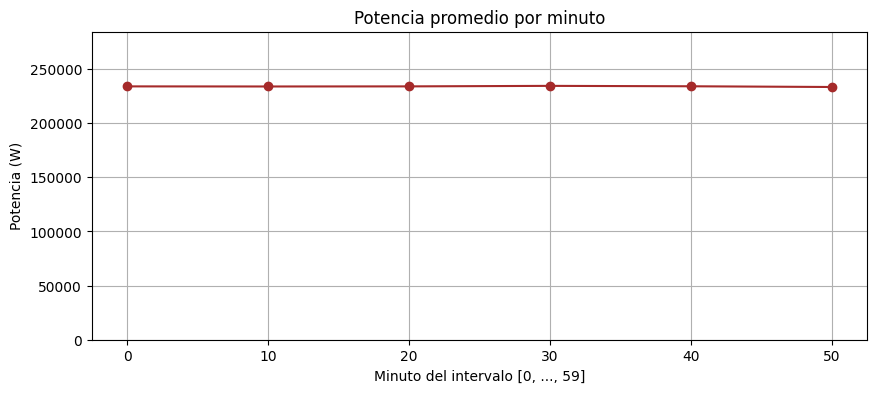

In [ ]:
potencia_minuto = df_consolidado_h.groupby('Minuto')['Potencia'].mean()

plt.figure(figsize=(10,4))
potencia_minuto.plot(marker='o', linestyle='-', color='brown')
plt.title('Potencia promedio por minuto')
plt.xlabel('Minuto del intervalo [0, ..., 59]')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_minuto.max() + 50000)
plt.xticks(range(0, 60, 10))
plt.grid(True)
plt.show()

Observamos que es una de las características candidatas de eliminación ya que no se ve ningún tipo de estacionalidad.

**Comportamiento de la potencia del viento cada hora durante el día**

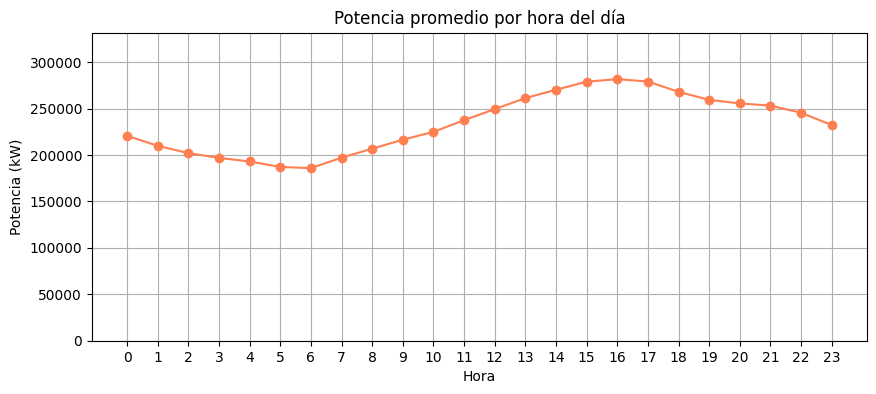

In [ ]:
potencia_hora = df_consolidado_h.groupby('Hora')['Potencia'].mean()

plt.figure(figsize=(10,4))
potencia_hora.plot(marker='o', color='coral')
plt.title('Potencia promedio por hora del día')
plt.xlabel('Hora')
plt.ylabel('Potencia (kW)')
plt.ylim(0, potencia_hora.max() + 50000)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Se observa que durante el día existe una estacionalidad, mayor potencia en la tarde y menor en la mañana

**Comportamiento de la potencia del viento por día de la semana**

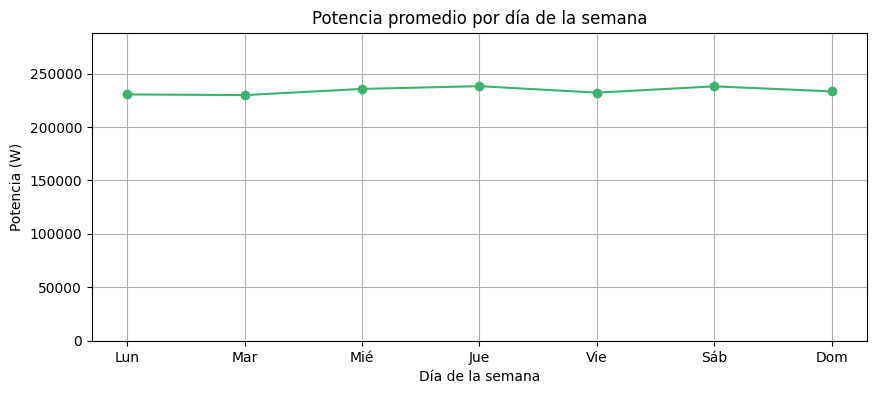

In [ ]:
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
potencia_dia = df_consolidado_h.groupby('DiaSemana')['Potencia'].mean()

plt.figure(figsize=(10,4))
potencia_dia.plot(marker='o', color='mediumseagreen')
plt.title('Potencia promedio por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_dia.max() + 50000)
plt.xticks(ticks=range(7), labels=dias)
plt.grid(True)
plt.show()

Observamos que es una de las características candidata de eliminación ya que no se ve ningún tipo de estacionalidad.

**Comportamiento de la potencia del viento por día del año**

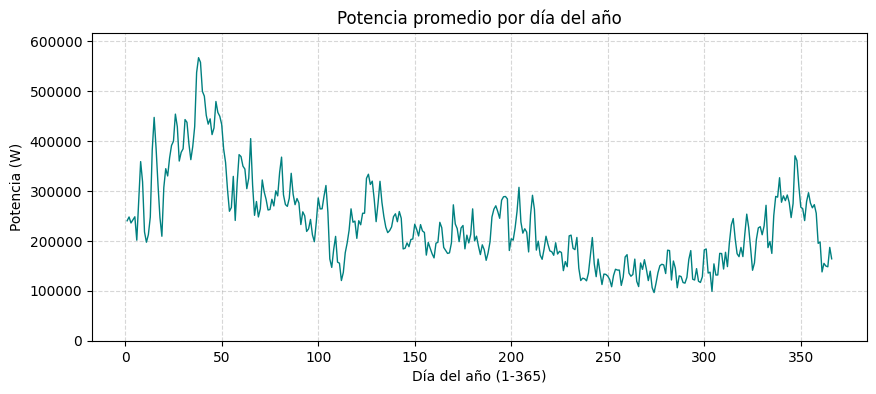

In [ ]:
potencia_dia_anio = df_consolidado_h.groupby('DiaDelAnio')['Potencia'].mean()

plt.figure(figsize=(10, 4))
plt.plot(potencia_dia_anio.index, potencia_dia_anio.values, color='teal', linewidth=1)
plt.title('Potencia promedio por día del año')
plt.xlabel('Día del año (1-365)')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_dia_anio.max() + 50000)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Se observa que durante el año existe una estacionalidad, mayor potencia en el primer semestre que en el segundo.

**Comportamiento de la potencia del viento en días desde el inicio**

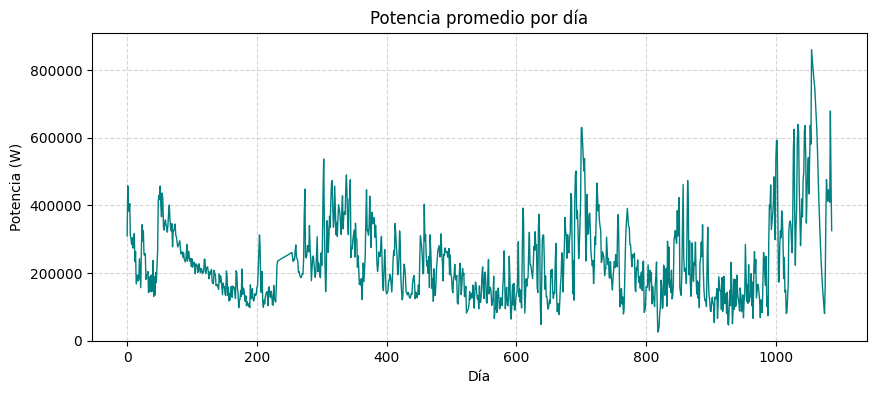

In [ ]:
potencia_dias = df_consolidado_h.groupby('DiasDesdeInicio')['Potencia'].mean()

plt.figure(figsize=(10, 4))
plt.plot(potencia_dias.index, potencia_dias.values, color='teal', linewidth=1)
plt.title('Potencia promedio por día')
plt.xlabel('Día')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_dias.max() + 50000)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Comportamiento de la potencia del viento cada día durante el mes**

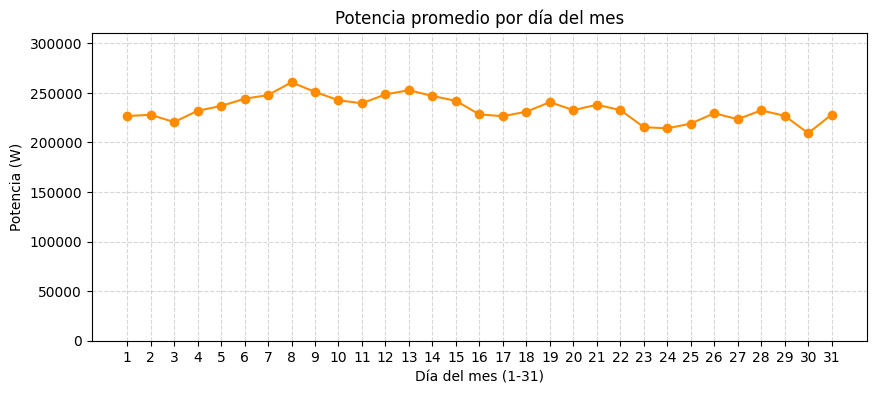

In [ ]:
potencia_dia_mes = df_consolidado_h.groupby('Dia')['Potencia'].mean()

plt.figure(figsize=(10,4))
plt.plot(potencia_dia_mes.index, potencia_dia_mes.values, marker='o', color='darkorange')
plt.title('Potencia promedio por día del mes')
plt.xlabel('Día del mes (1-31)')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_dia_mes.max() + 50000)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 32))
plt.show()

Observamos que es una de las características candidata de eliminación ya que no se ve ningún tipo de estacionalidad.

**Comportamiento de la potencia del viento cada mes durante el año**

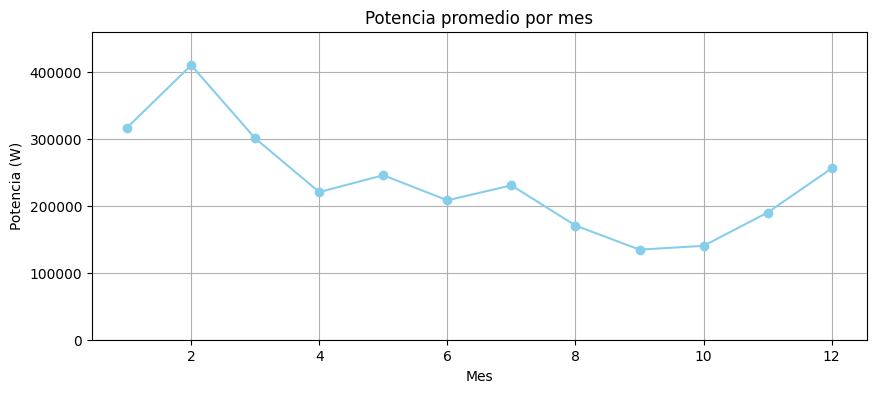

In [ ]:
potencia_mes = df_consolidado_h.groupby('Mes')['Potencia'].mean()

plt.figure(figsize=(10,4))
potencia_mes.plot(marker='o', color='skyblue')
#potencia_mes.plot(kind='bar', color='skyblue')
plt.title('Potencia promedio por mes')
plt.xlabel('Mes')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_mes.max() + 50000)
plt.grid(True)
plt.show()

Se observa estacionalidad, el primer semestre del año se observa que se obtiene mayor potencia del viento respecto al segundo semestre

**Comportamiento de la potencia del viento cada mes**

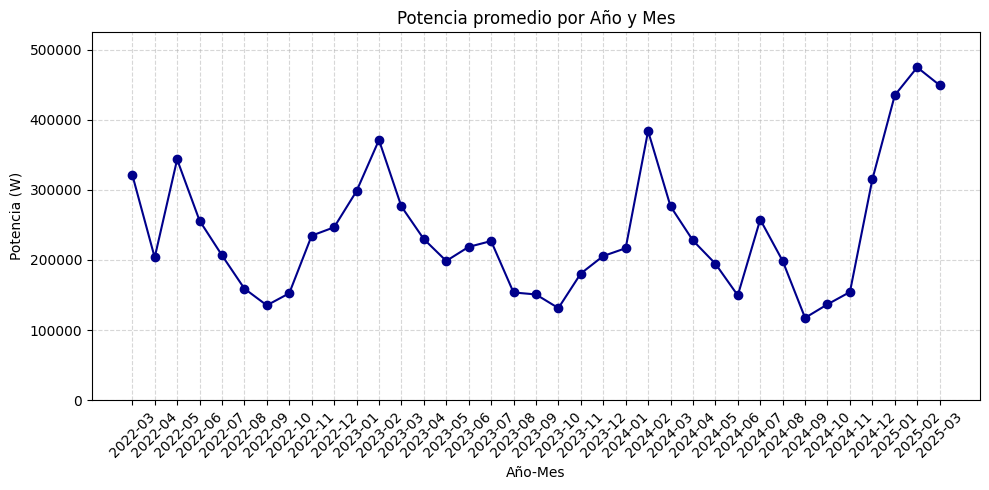

In [ ]:
potencia_aniomes = df_consolidado_h.groupby('AnioMes')['Potencia'].mean()

plt.figure(figsize=(10, 5))
plt.plot(potencia_aniomes.index, potencia_aniomes.values, marker='o', linestyle='-', color='darkblue')
plt.title('Potencia promedio por Año y Mes')
plt.xlabel('Año-Mes')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_aniomes.max() + 50000)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Observar el comportamiento de los meses a través de los años corrobora que existe una estacionalidad.

**Comportamiento de la potencia del viento por semestre del año**

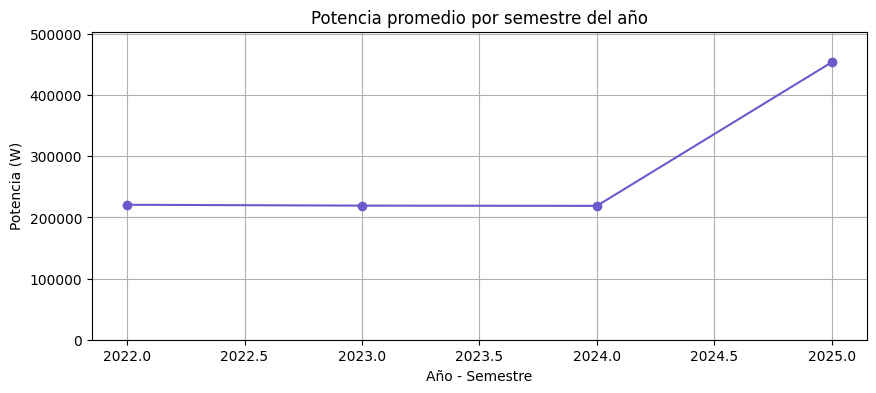

In [ ]:
potencia_anual = df_consolidado_h.groupby('Anio')['Potencia'].mean()

plt.figure(figsize=(10, 4))
potencia_anual.plot(marker='o', color='slateblue')
plt.title('Potencia promedio por semestre del año')
plt.xlabel('Año - Semestre')
plt.ylabel('Potencia (W)')
plt.ylim(0, potencia_anual.max() + 50000)
plt.grid(True)

Debido a que son pocos años no se ve una estacionalidad.

Se concluye que las variables hora, día del año son esenciales en el estudio ya que la potencia tiene un comportamiento estacional en estas periodicidades.

Cuál periodicidad tiene más variabilidad explicada sobre la potencia, usando métricas estadísticas simples

In [ ]:
# Crea columnas temporales
df = df_consolidado_h.copy()

# Variables a analizar
vars_temporales = ['Anio', 'Mes', 'AnioMes', 'Dia', 'DiaSemana','DiaDelAnio','Hora','Minuto','DiasDesdeInicio']

# Varianza total de la potencia
var_total = df['Potencia'].var()

# Diccionario para guardar varianza explicada
var_explicada = {}

# Cálculo
for var in vars_temporales:
    media_por_grupo = df.groupby(var)['Potencia'].mean()
    potencia_media_mapeada = df[var].map(media_por_grupo)
    var_modelo = np.var(potencia_media_mapeada)
    porcentaje_explicado = (var_modelo / var_total) * 100
    var_explicada[var] = porcentaje_explicado

# Mostrar en tabla ordenada
df_resultados = pd.DataFrame.from_dict(var_explicada, orient='index', columns=['Varianza Explicada (%)'])
df_resultados = df_resultados.sort_values(by='Varianza Explicada (%)', ascending=False)
print(df_resultados)

                 Varianza Explicada (%)
DiasDesdeInicio               19.732343
DiaDelAnio                    11.015291
AnioMes                       10.587389
Mes                            7.775058
Anio                           4.440163
Hora                           1.357841
Dia                            0.200225
DiaSemana                      0.014102
Minuto                         0.000132


Generamos dataset con las características de periodicidad más relacionada con la potencia.

In [ ]:
df_consolidado_h = df_consolidado_c.copy()
df_consolidado_h.loc[:, 'AnioMes'] = df_consolidado_h['FechaObservacion'].dt.to_period('M').astype(str)
df_consolidado_h.loc[:, 'DiaDelAnio'] = df_consolidado_h['FechaObservacion'].dt.dayofyear
df_consolidado_h.loc[:, 'Hora'] = df_consolidado_h['FechaObservacion'].dt.hour


# Codificación cíclica
df_consolidado_h['DiaDelAnio_sin'] = np.sin(2 * np.pi * df_consolidado_h['DiaDelAnio'] / 365)
df_consolidado_h['DiaDelAnio_cos'] = np.cos(2 * np.pi * df_consolidado_h['DiaDelAnio'] / 365)

df_consolidado_h['Hora_sin'] = np.sin(2 * np.pi * df_consolidado_h['Hora'] / 24)
df_consolidado_h['Hora_cos'] = np.cos(2 * np.pi * df_consolidado_h['Hora'] / 24)

# Codificación numérica del año y mes
df_consolidado_h['AnioMes'] = pd.to_datetime(df_consolidado_h['AnioMes'])
df_consolidado_h['AnioMesOrdinal'] = df_consolidado_h['AnioMes'].map(lambda x: x.toordinal())

# Dias desde el inicio
df_consolidado_h['DiasDesdeInicio'] = (df_consolidado_h['FechaObservacion'] - df_consolidado_h['FechaObservacion'].min()).dt.days
periodo_total_dias = df_consolidado_h['DiasDesdeInicio'].max() + 1
df_consolidado_h['DiasDesdeInicio_sin'] = np.sin(2 * np.pi * df_consolidado_h['DiasDesdeInicio'] / periodo_total_dias)
df_consolidado_h['DiasDesdeInicio_cos'] = np.cos(2 * np.pi * df_consolidado_h['DiasDesdeInicio'] / periodo_total_dias)

In [ ]:
print(df_consolidado_h.head())

   CodigoEstacion    Latitud   Longitud    FechaObservacion  Direccion  \
0        14015010  10.794167 -75.260556 2022-03-18 00:00:00       38.0   
1        14015010  10.794167 -75.260556 2022-03-18 00:10:00       38.0   
2        14015010  10.794167 -75.260556 2022-03-18 00:20:00       38.0   
3        14015010  10.794167 -75.260556 2022-03-18 00:30:00       38.0   
4        14015010  10.794167 -75.260556 2022-03-18 00:40:00       38.0   

   Humedad  Precipitacion  Presion  Temperatura  Velocidad  ...  DiaDelAnio  \
0     76.0            0.0   1007.4         29.0        4.1  ...          77   
1     76.0            0.0   1007.4         29.0        4.1  ...          77   
2     76.0            0.0   1007.4         29.0        4.1  ...          77   
3     76.0            0.0   1007.4         29.0        4.1  ...          77   
4     76.0            0.0   1007.4         29.0        4.1  ...          77   

  Hora  DiaDelAnio_sin  DiaDelAnio_cos  Hora_sin  Hora_cos  AnioMesOrdinal  \
0 

La variable minuto no es relevante, agrupamos por todas las características menos las correspondiente a las observaciones, a las cuales le generamos la mediana.

In [ ]:
df_consolidado_h['FechaObservacion'] = df_consolidado_h['FechaObservacion'].dt.floor('h')

df_consolidado_h = df_consolidado_h.groupby([
    'CodigoEstacion', 'Latitud', 'Longitud', 'FechaObservacion', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos', 'Hora',
    'Hora_sin', 'Hora_cos', 'DiasDesdeInicio', 'DiasDesdeInicio_sin', 'DiasDesdeInicio_cos'
]).agg({
    'Direccion': 'median', 'Humedad': 'median', 'Precipitacion': 'median', 'Presion': 'median', 'Temperatura': 'median', 'Velocidad': 'median','Potencia': 'median'
}).reset_index()

In [ ]:
print(df_consolidado_h.head())
print(df_consolidado_h.tail())

   CodigoEstacion    Latitud   Longitud    FechaObservacion  DiaDelAnio  \
0        14015010  10.794167 -75.260556 2022-03-18 00:00:00          77   
1        14015010  10.794167 -75.260556 2022-03-18 01:00:00          77   
2        14015010  10.794167 -75.260556 2022-03-18 02:00:00          77   
3        14015010  10.794167 -75.260556 2022-03-18 03:00:00          77   
4        14015010  10.794167 -75.260556 2022-03-18 04:00:00          77   

   DiaDelAnio_sin  DiaDelAnio_cos  Hora  Hora_sin  Hora_cos  DiasDesdeInicio  \
0        0.970064         0.24285     0  0.000000  1.000000                0   
1        0.970064         0.24285     1  0.258819  0.965926                0   
2        0.970064         0.24285     2  0.500000  0.866025                0   
3        0.970064         0.24285     3  0.707107  0.707107                0   
4        0.970064         0.24285     4  0.866025  0.500000                0   

   DiasDesdeInicio_sin  DiasDesdeInicio_cos  Direccion  Humedad  \
0

In [ ]:
print(df_consolidado_h.shape)

(104352, 20)


## **Reducción de dimensiones respecto de las observaciones**

Descripción de las variables

In [ ]:
df_consolidado_f = df_consolidado_h.copy()
print(df_consolidado_f.describe())

       CodigoEstacion        Latitud       Longitud  \
count    1.043520e+05  104352.000000  104352.000000   
mean     1.877507e+07      11.550042     -76.406889   
min      1.401501e+07      10.794167     -81.358000   
25%      1.476504e+07      10.887042     -76.784917   
50%      1.602004e+07      11.023000     -75.020278   
75%      2.003006e+07      11.686000     -74.642250   
max      2.904519e+07      13.360000     -74.229000   
std      6.027756e+06       1.051776       2.881747   

                    FechaObservacion     DiaDelAnio  DiaDelAnio_sin  \
count                         104352  104352.000000   104352.000000   
mean   2023-09-12 11:30:00.000000256     184.087397       -0.007806   
min              2022-03-18 00:00:00       1.000000       -0.999991   
25%              2022-12-14 17:45:00      94.000000       -0.711657   
50%              2023-09-12 11:30:00     185.000000       -0.008607   
75%              2024-06-10 05:15:00     275.000000        0.693281   
max    

Escalado de las características del dataset debido a que tienen diferentes unidades

Excluimos la variable del código de la estación ya que esta representada con la longitud y latitud (posición espacial)

In [ ]:
c = ['Latitud', 'Longitud', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos', 'Hora',
    'Hora_sin', 'Hora_cos', 'DiasDesdeInicio','DiasDesdeInicio_sin', 'DiasDesdeInicio_cos', 'Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad','Potencia']

Se utiliza la matriz de corelación entre variables no temporales

In [ ]:
c = ['Latitud', 'Longitud', 'Direccion', 'Humedad', 'Precipitacion', 'Presion', 'Temperatura', 'Velocidad','Potencia']

df_consolidado_e = df_consolidado_f[c]

min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(df_consolidado_e)

Validamos que tanta variabilidad tiene el conjunto de datos mediante PCA, esto es determinante para que un modelo pueda generalizar de una mejor forma.

In [ ]:
#Análisis de componentes principales
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(features_norm)
print("Componentes lineales:\n", estimator.components_)
print("\nRatio de variabilidad: ", estimator.explained_variance_ratio_)
print("\nVariabilidad total: ",sum(estimator.explained_variance_ratio_))

Componentes lineales:
 [[ 6.92067822e-01 -6.87968126e-01 -1.40381642e-01  5.07493214e-02
  -1.87125052e-04  2.41680945e-02 -6.87126286e-03  9.95251662e-02
   1.22159257e-01]
 [-2.02804263e-01  6.18016243e-02 -4.85417124e-01 -1.68210705e-01
   2.42108990e-03 -1.41887914e-01  1.15846845e-01  5.52913815e-01
   5.93172947e-01]]

Ratio de variabilidad:  [0.55994377 0.16601367]

Variabilidad total:  0.72595743900016


El resultado nos genera un variabilidad del 72.59%

Realizamos una matriz de correlación con el fin de encontrar aquellas características que tengan una mayor correlación con nuestra variable objetivo.

<Axes: >

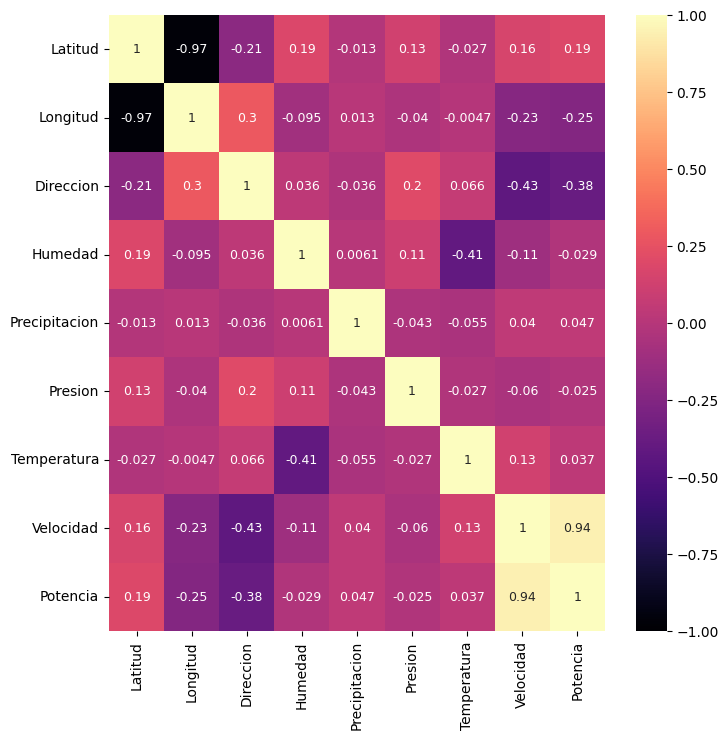

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_consolidado_e.iloc[:,:9].corr(), vmin=-1, vmax=1, cmap='magma', annot=True, annot_kws = {'size': 9})

Las características con mayor correlación respecto al target son 'Latitud', 'Longitud', 'Direccion' y 'Velocidad'. Las variables de temporalidad las incluyo después del análisis

<Axes: >

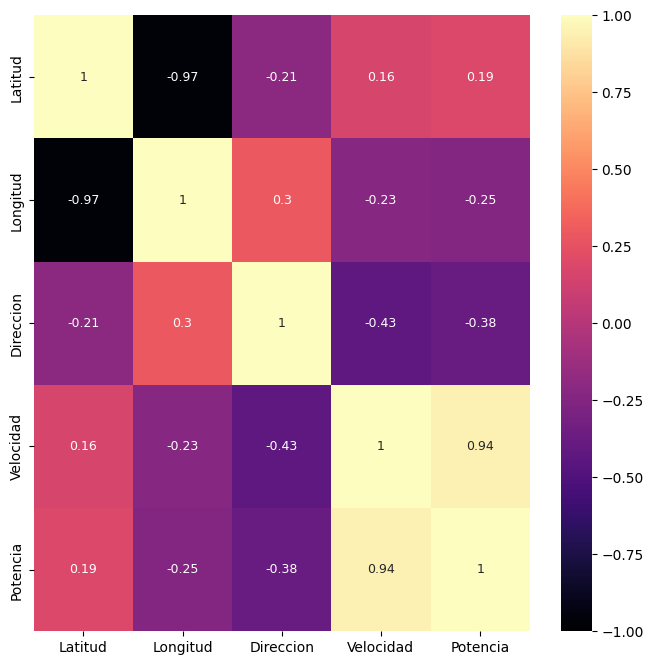

In [ ]:
c = ['Latitud','Longitud','Direccion','Velocidad','Potencia']
plt.figure(figsize=(8, 8))
sns.heatmap(df_consolidado_e[c].iloc[:,:9].corr(), vmin=-1, vmax=1, cmap='magma', annot=True, annot_kws = {'size': 9})

Volvemos a validar que tanta variabilidad tiene el conjunto de datos mediante PCA con las características seleccionadas.

In [ ]:
#Normalización del conjunto de datos
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features_norm = min_max_scaler.fit_transform(df_consolidado_e[c])

#Análisis de componentes principales
from sklearn.decomposition import PCA
estimator = PCA (n_components = 2)
X_pca = estimator.fit_transform(features_norm)
print("Componentes lineales:\n", estimator.components_)
print("\nRatio de variabilidad: ", estimator.explained_variance_ratio_)
print("\nVariabilidad total: ",sum(estimator.explained_variance_ratio_))

Componentes lineales:
 [[ 0.6919037  -0.68957676 -0.14230049  0.10131064  0.12344999]
 [-0.20863159  0.08670441 -0.49290011  0.56623464  0.62079224]]

Ratio de variabilidad:  [0.69925726 0.20157653]

Variabilidad total:  0.9008337929539421


La variabilidad subio al 90%, pero por características podemos eliminar características del código de estación ya que estan representadas con la longitud y la latitud.

Validamos las dimensiones del nuevo dataset

In [ ]:
c = ['Latitud', 'Longitud', 'FechaObservacion', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos', 'Hora',
    'Hora_sin', 'Hora_cos', 'DiasDesdeInicio','DiasDesdeInicio_sin', 'DiasDesdeInicio_cos', 'Direccion', 'Velocidad','Potencia']

print(df_consolidado_f[c].shape)

(104352, 15)


Guardo los resultados.

In [ ]:
# Guardo el resultado del dataframe para realizarle el preprocesamiento
df_consolidado_f[c].to_csv('drive/MyDrive/viento/Viento.csv', index=False)

## **Busqueda de mejores hiperparámetros con el algoritmo WOA**

In [ ]:
!pip install lightgbm tensorflow scikit-learn numpy pandas matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import joblib
import time
from scipy.stats import boxcox

In [ ]:
# --- Configuración reproducible ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler

np.random.seed(42)
tf.random.set_seed(42)

# --- Función COMPLETA de optimización WOA ---
def whale_optimization_algorithm(X_train, y_train, X_val, y_val, n_iter=10, n_whales=5):
    search_space = {
        'lstm_units': (64, 256),
        'learning_rate': (0.0001, 0.01),
        'batch_size': (32, 256),
        'dropout_rate': (0.1, 0.4),
        'num_layers': (1, 3)
    }

    optimization_history = {'iteration': [], 'best_loss': [], 'params': []}
    whales = []

    # Inicializar ballenas con parámetros aleatorios
    for _ in range(n_whales):
        whale = {
            'lstm_units': int(np.random.uniform(*search_space['lstm_units'])),
            'learning_rate': np.exp(np.random.uniform(np.log(search_space['learning_rate'][0]),
                                                    np.log(search_space['learning_rate'][1]))),
            'batch_size': int(np.random.uniform(*search_space['batch_size'])),
            'dropout_rate': round(np.random.uniform(*search_space['dropout_rate']), 2),
            'num_layers': int(np.random.uniform(*search_space['num_layers']))
        }
        whales.append(whale)

    best_whale = None
    best_val_loss = float('inf')

    for iteration in range(n_iter):
        print(f"\nIteración {iteration + 1}/{n_iter}")

        for whale in whales:
            # Construir modelo LSTM con parámetros actuales
            model = Sequential()
            model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

            for i in range(whale['num_layers']):
                return_sequences = (i < whale['num_layers'] - 1)
                model.add(LSTM(
                    whale['lstm_units'] // (2 ** i),
                    return_sequences=return_sequences,
                    kernel_regularizer=l2(0.001)
                ))
                model.add(BatchNormalization())
                model.add(Dropout(whale['dropout_rate']))

            model.add(Dense(y_train.shape[1]))
            model.compile(optimizer=Adam(whale['learning_rate']), loss='mae')

            # Entrenamiento con early stopping
            es = EarlyStopping(patience=5, verbose=0)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=30,
                batch_size=whale['batch_size'],
                verbose=0,
                callbacks=[es]
            )

            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_whale = whale.copy()
                print(f"⭐ Nuevo mejor: Loss={val_loss:.4f} | Params={whale}")

        optimization_history['iteration'].append(iteration + 1)
        optimization_history['best_loss'].append(best_val_loss)
        optimization_history['params'].append(best_whale.copy())

    return best_whale, optimization_history

# --- Preprocesamiento para WOA ---
ruta_archivo = 'drive/MyDrive/viento/Viento.csv'
df = pd.read_csv(ruta_archivo, parse_dates=['FechaObservacion'])
df['FechaObservacion'] = pd.to_datetime(df['FechaObservacion'])
df = df.sort_values(['FechaObservacion', 'Latitud', 'Longitud'])
df = df.drop(columns=['FechaObservacion'])

features = ['Latitud', 'Longitud', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos',
            'Hora', 'Hora_sin', 'Hora_cos', 'DiasDesdeInicio', 'DiasDesdeInicio_sin',
            'DiasDesdeInicio_cos', 'Direccion', 'Velocidad']
target = 'Potencia'

df['Potencia_boxcox'], lambda_ = boxcox(df['Potencia'] + 1)  # +1 para evitar ceros

target = 'Potencia_boxcox'

#df['Potencia_log'] = np.log1p(df['Potencia'])
#target = 'Potencia_log'

scaler_x = RobustScaler()
scaler_y = RobustScaler()
X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Crear secuencias
X_seq, y_seq = [], []
total_samples = len(X) // 4  # 4 estaciones
for i in range(total_samples - 24 - 24):  # window=24, horizon=24
    X_seq.append(X[i*4 : (i + 24)*4])
    y_seq.append(y[(i + 24)*4 : (i + 24 + 24)*4].flatten())

X_seq, y_seq = np.array(X_seq), np.array(y_seq)
X_train, X_val = X_seq[:int(0.8*len(X_seq))], X_seq[int(0.8*len(X_seq)):]
y_train, y_val = y_seq[:int(0.8*len(y_seq))], y_seq[int(0.8*len(y_seq)):]

# --- Ejecutar WOA ---
best_params, _ = whale_optimization_algorithm(X_train, y_train, X_val, y_val, n_iter=10, n_whales=5)
print("\n⭐ Mejores hiperparámetros encontrados:")
for param, value in best_params.items():
    print(f"- {param}: {value}")


Iteración 1/10
⭐ Nuevo mejor: Loss=0.4551 | Params={'lstm_units': 135, 'learning_rate': np.float64(0.007969454818643935), 'batch_size': 195, 'dropout_rate': 0.28, 'num_layers': 1}

Iteración 2/10
⭐ Nuevo mejor: Loss=0.4487 | Params={'lstm_units': 135, 'learning_rate': np.float64(0.007969454818643935), 'batch_size': 195, 'dropout_rate': 0.28, 'num_layers': 1}

Iteración 3/10

Iteración 4/10

Iteración 5/10

Iteración 6/10

Iteración 7/10

Iteración 8/10
⭐ Nuevo mejor: Loss=0.4345 | Params={'lstm_units': 135, 'learning_rate': np.float64(0.007969454818643935), 'batch_size': 195, 'dropout_rate': 0.28, 'num_layers': 1}

Iteración 9/10

Iteración 10/10

⭐ Mejores hiperparámetros encontrados:
- lstm_units: 135
- learning_rate: 0.007969454818643935
- batch_size: 195
- dropout_rate: 0.28
- num_layers: 1


## **Modelo LSTM**

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# Fijar semillas para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# 1. Carga y Preprocesamiento de Datos
ruta_archivo = 'drive/MyDrive/viento/Viento.csv'
df = pd.read_csv(ruta_archivo, parse_dates=['FechaObservacion'])
df = df.sort_values(['Latitud', 'Longitud', 'FechaObservacion'])

features = ['Latitud', 'Longitud', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos',
            'Hora', 'Hora_sin', 'Hora_cos', 'DiasDesdeInicio', 'DiasDesdeInicio_sin',
            'DiasDesdeInicio_cos', 'Direccion', 'Velocidad']
target = 'Potencia'
data = df[features + [target]].copy()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

scaler = MinMaxScaler()
scaler.fit(train_data[features + [target]])
train_scaled = scaler.transform(train_data[features + [target]])
test_scaled = scaler.transform(test_data[features + [target]])

# 2. Preparación de Secuencias para LSTM (Asegúrate de que esto ya esté hecho)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :-1])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 24
X_train_lstm_pure, y_train_lstm_pure = create_sequences(train_scaled, n_steps)
X_test_lstm_pure, y_test_lstm_pure = create_sequences(test_scaled, n_steps)

# 3. Construcción y Entrenamiento del Modelo LSTM Puro
lstm_units = 135
learning_rate = 0.007969454818643935
batch_size = 195
dropout_rate = 0.28
num_layers = 1

lstm_model_pure = Sequential()
lstm_model_pure.add(LSTM(units=lstm_units, activation='relu', input_shape=(n_steps, X_train_lstm_pure.shape[2])))
lstm_model_pure.add(Dropout(dropout_rate))
lstm_model_pure.add(Dense(units=1))

lstm_model_pure.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
val_size = int(0.2 * len(X_train_lstm_pure))
X_val_lstm_pure, y_val_lstm_pure = X_train_lstm_pure[-val_size:], y_train_lstm_pure[-val_size:]
X_train_lstm_pure_trimmed, y_train_lstm_pure_trimmed = X_train_lstm_pure[:-val_size], y_train_lstm_pure[:-val_size]

lstm_history_pure = lstm_model_pure.fit(X_train_lstm_pure_trimmed, y_train_lstm_pure_trimmed,
                                        epochs=100,
                                        batch_size=batch_size,
                                        validation_data=(X_val_lstm_pure, y_val_lstm_pure),
                                        callbacks=[early_stopping], verbose=0)

# 4. Predicción del Modelo LSTM Puro
lstm_predictions_scaled_pure = lstm_model_pure.predict(X_test_lstm_pure)

# Invertir la escala
lstm_predictions_pure = scaler.inverse_transform(np.concatenate((test_data[features].values[n_steps:], lstm_predictions_scaled_pure), axis=1))[:, -1]
actual_values_pure = test_data[target].values[n_steps:]

# 5. Calcular Métricas para el Modelo LSTM Puro
mae_lstm_pure = mean_absolute_error(actual_values_pure, lstm_predictions_pure)
medae_lstm_pure = median_absolute_error(actual_values_pure, lstm_predictions_pure)
mse_lstm_pure = mean_squared_error(actual_values_pure, lstm_predictions_pure)
rmse_lstm_pure = np.sqrt(mse_lstm_pure)
mape_lstm_pure = mean_absolute_percentage_error(actual_values_pure, lstm_predictions_pure)
smape_lstm_pure = symmetric_mean_absolute_percentage_error(actual_values_pure, lstm_predictions_pure)
r2_lstm_pure = r2_score(actual_values_pure, lstm_predictions_pure)

print("\nMétricas del Modelo LSTM Puro:")
print(f'MAE: {mae_lstm_pure:.2f}, MedAE: {medae_lstm_pure:.2f}, MSE: {mse_lstm_pure:.2f}, RMSE: {rmse_lstm_pure:.2f}')
print(f'MAPE: {mape_lstm_pure:.2f}%, SMAPE: {smape_lstm_pure:.2f}%, R^2: {r2_lstm_pure:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Métricas del Modelo LSTM Puro:
MAE: 125135.60, MedAE: 91469.77, MSE: 28539987359.66, RMSE: 168937.82
MAPE: 476.03%, SMAPE: 59.17%, R^2: 0.66


**Métricas estadísticas**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Symmetric Mean Absolute Percentage Error (SMAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Supongamos que ya tienes 'actual_values' (los valores reales de 'Potencia')
# y 'hybrid_predictions' (las predicciones de tu modelo híbrido)

# Calcular MAE
mae_p = mean_absolute_error(actual_values_pure, lstm_predictions_pure)
print(f'MAE: {mae_p:.2f}')

# Calcular MedAE
medae_p = median_absolute_error(actual_values_pure, lstm_predictions_pure)
print(f'MedAE: {medae_p:.2f}')

# Calcular MSE
mse_p = mean_squared_error(actual_values_pure, lstm_predictions_pure)
print(f'MSE: {mse_p:.2f}')

# Calcular RMSE
rmse_p = np.sqrt(mse_p)
print(f'RMSE: {rmse_p:.2f}')

# Calcular MAPE
# ¡Ojo! El MAPE puede dar resultados no fiables si hay muchos valores cercanos a cero en y_true.
mape_p = mean_absolute_percentage_error(actual_values_pure, lstm_predictions_pure)
print(f'MAPE: {mape_p:.2f}%')

# Calcular SMAPE
smape_p = symmetric_mean_absolute_percentage_error(actual_values_pure, lstm_predictions_pure)
print(f'SMAPE: {smape_p:.2f}%')

# Calcular R^2
r_squared_p = r2_score(actual_values_pure, lstm_predictions_pure)
print(f'R^2: {r_squared_p:.2f}')

MAE: 125135.60
MedAE: 91469.77
MSE: 28539987359.66
RMSE: 168937.82
MAPE: 476.03%
SMAPE: 59.17%
R^2: 0.66


## **Modelo híbrido LSTM + LightBGM**

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

# Fijar semillas para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :-1])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

# 1. Carga de datos
ruta_archivo = 'drive/MyDrive/viento/Viento.csv'
df = pd.read_csv(ruta_archivo, parse_dates=['FechaObservacion'])
df = df.sort_values(['Latitud', 'Longitud', 'FechaObservacion'])

features = ['Latitud', 'Longitud', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos',
            'Hora', 'Hora_sin', 'Hora_cos', 'DiasDesdeInicio', 'DiasDesdeInicio_sin',
            'DiasDesdeInicio_cos', 'Direccion', 'Velocidad']
target = 'Potencia'
data = df[features + [target]].copy()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

scaler = MinMaxScaler()
scaler.fit(train_data[features + [target]])
train_scaled = scaler.transform(train_data[features + [target]])
test_scaled = scaler.transform(test_data[features + [target]])

# 2. Preparación de Secuencias para LSTM
n_steps = 24
X_train_lstm, y_train_lstm = create_sequences(train_scaled, n_steps)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, n_steps)

# 3. Construcción y Entrenamiento del Modelo LSTM
lstm_model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(n_steps, X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
val_size = int(0.2 * len(X_train_lstm))
X_val_lstm, y_val_lstm = X_train_lstm[-val_size:], y_train_lstm[-val_size:]
X_train_lstm_trimmed, y_train_lstm_trimmed = X_train_lstm[:-val_size], y_train_lstm[:-val_size]

lstm_history = lstm_model.fit(X_train_lstm_trimmed, y_train_lstm_trimmed,
                             epochs=50,
                             batch_size=32,
                             validation_data=(X_val_lstm, y_val_lstm),
                             callbacks=[early_stopping],
                             verbose=0)

# 4. Extracción de Características del LSTM
lstm_train_features = lstm_model.predict(X_train_lstm)
lstm_test_features = lstm_model.predict(X_test_lstm)

# 5. Preparación de Datos para LightGBM
X_train_lgbm = np.concatenate((train_scaled[n_steps:, :-1], lstm_train_features), axis=1)
y_train_lgbm = y_train_lstm
X_test_lgbm = np.concatenate((test_scaled[n_steps:, :-1], lstm_test_features), axis=1)
y_test_lgbm = y_test_lstm

# 6. Construcción y Entrenamiento del Modelo LightGBM
lgbm_model = lgb.LGBMRegressor(objective='mae',
                             metric='mae',
                             n_estimators=100,
                             learning_rate=0.05,
                             num_leaves=31,
                             random_state=seed_value) # Fijar la semilla en LightGBM

lgbm_model.fit(X_train_lgbm, y_train_lgbm)

# 7. Predicción y Evaluación
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
hybrid_predictions_scaled = lgbm_model.predict(X_test_lgbm)

lstm_predictions = scaler.inverse_transform(np.concatenate((test_data[features].values[n_steps:], lstm_predictions_scaled), axis=1))[:, -1]
hybrid_predictions_input = np.concatenate((test_data[features].values[n_steps:], hybrid_predictions_scaled.reshape(-1, 1)), axis=1)
hybrid_predictions = scaler.inverse_transform(hybrid_predictions_input)[:, -1]
actual_values = test_data[target].values[n_steps:]

# Calcular el MAE para ambos modelos
mae_lstm = mean_absolute_error(actual_values, lstm_predictions)
mae_hibrido = mean_absolute_error(actual_values, hybrid_predictions)

print(f'MAE del modelo LSTM: {mae_lstm:.2f}')
print(f'MAE del modelo híbrido (LSTM + LightGBM): {mae_hibrido:.2f}')

from sklearn.metrics import mean_squared_error
rmse_lstm = np.sqrt(mean_squared_error(actual_values, lstm_predictions))
rmse_hibrido = np.sqrt(mean_squared_error(actual_values, hybrid_predictions))
print(f'RMSE del modelo LSTM: {rmse_lstm:.2f}')
print(f'RMSE del modelo híbrido (LSTM + LightGBM): {rmse_hibrido:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2350
[LightGBM] [Info] Number of data points in the train set: 83457, number of used features: 14
[LightGBM] [Info] Start training from score 0.087512
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE del modelo LSTM: 115164.36
MAE del modelo híbrido (LSTM + LightGBM): 14445.35
RMSE del modelo LSTM: 163328.53
RMSE del modelo híbrido (LSTM + LightGBM): 38203.70


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Métricas estadísticas**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Symmetric Mean Absolute Percentage Error (SMAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Supongamos que ya tienes 'actual_values' (los valores reales de 'Potencia')
# y 'hybrid_predictions' (las predicciones de tu modelo híbrido)

# Calcular MAE
mae_ll = mean_absolute_error(actual_values, hybrid_predictions)
print(f'MAE: {mae_ll:.2f}')

# Calcular MedAE
medae_ll = median_absolute_error(actual_values, hybrid_predictions)
print(f'MedAE: {medae_ll:.2f}')

# Calcular MSE
mse_ll = mean_squared_error(actual_values, hybrid_predictions)
print(f'MSE: {mse_ll:.2f}')

# Calcular RMSE
rmse_ll = np.sqrt(mse_ll)
print(f'RMSE: {rmse_ll:.2f}')

# Calcular MAPE
# ¡Ojo! El MAPE puede dar resultados no fiables si hay muchos valores cercanos a cero en y_true.
mape_ll = mean_absolute_percentage_error(actual_values, hybrid_predictions)
print(f'MAPE: {mape_ll:.2f}%')

# Calcular SMAPE
smape_ll = symmetric_mean_absolute_percentage_error(actual_values, hybrid_predictions)
print(f'SMAPE: {smape_ll:.2f}%')

# Calcular R^2
r_squared_ll = r2_score(actual_values, hybrid_predictions)
print(f'R^2: {r_squared_ll:.2f}')

MAE: 14445.35
MedAE: 4146.78
MSE: 1459522927.80
RMSE: 38203.70
MAPE: 42.73%
SMAPE: 11.17%
R^2: 0.98


## **Modelo híbrido LSTM + XGBoost**

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
import tensorflow as tf

# Fijar semillas para reproducibilidad
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# 1. Carga y Preprocesamiento de Datos
ruta_archivo = 'drive/MyDrive/viento/Viento.csv'
df = pd.read_csv(ruta_archivo, parse_dates=['FechaObservacion'])
df = df.sort_values(['Latitud', 'Longitud', 'FechaObservacion'])

features = ['Latitud', 'Longitud', 'DiaDelAnio', 'DiaDelAnio_sin', 'DiaDelAnio_cos',
            'Hora', 'Hora_sin', 'Hora_cos', 'DiasDesdeInicio', 'DiasDesdeInicio_sin',
            'DiasDesdeInicio_cos', 'Direccion', 'Velocidad']
target = 'Potencia'
data = df[features + [target]].copy()

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

scaler = MinMaxScaler()
scaler.fit(train_data[features + [target]])
train_scaled = scaler.transform(train_data[features + [target]])
test_scaled = scaler.transform(test_data[features + [target]])

# 2. Preparación de Secuencias para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :-1])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 24
X_train_lstm, y_train_lstm = create_sequences(train_scaled, n_steps)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, n_steps)

# 3. Construcción y Entrenamiento del Modelo LSTM
lstm_model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(n_steps, X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
val_size = int(0.2 * len(X_train_lstm))
X_val_lstm, y_val_lstm = X_train_lstm[-val_size:], y_train_lstm[-val_size:]
X_train_lstm_trimmed, y_train_lstm_trimmed = X_train_lstm[:-val_size], y_train_lstm[:-val_size]
lstm_history = lstm_model.fit(X_train_lstm_trimmed, y_train_lstm_trimmed,
                             epochs=50, batch_size=32,
                             validation_data=(X_val_lstm, y_val_lstm),
                             callbacks=[early_stopping], verbose=0)

# 4. Extracción de Características del LSTM
lstm_train_features = lstm_model.predict(X_train_lstm)
lstm_test_features = lstm_model.predict(X_test_lstm)

# 5. Preparación de Datos para XGBoost
X_train_xgb = np.concatenate((train_scaled[n_steps:, :-1], lstm_train_features), axis=1)
y_train_xgb = y_train_lstm
X_test_xgb = np.concatenate((test_scaled[n_steps:, :-1], lstm_test_features), axis=1)
y_test_xgb = y_test_lstm

# 6. Construcción y Entrenamiento del Modelo XGBoost
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 learning_rate=0.05,
                                 max_depth=5,
                                 random_state=seed_value) # Fijar la semilla en XGBoost

xgboost_model.fit(X_train_xgb, y_train_xgb)

# 7. Predicción y Evaluación
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
xgboost_predictions_scaled = xgboost_model.predict(X_test_xgb)

# Invertir la escala
# Usamos test_data[features].values para obtener las características originales del conjunto de prueba
lstm_predictions = scaler.inverse_transform(np.concatenate((test_data[features].values[n_steps:], lstm_predictions_scaled), axis=1))[:, -1]
xgboost_predictions_input = np.concatenate((test_data[features].values[n_steps:], xgboost_predictions_scaled.reshape(-1, 1)), axis=1)
xgboost_predictions = scaler.inverse_transform(xgboost_predictions_input)[:, -1]
actual_values = test_data[target].values[n_steps:]

# Calcular métricas para LSTM
mae_lstm = mean_absolute_error(actual_values, lstm_predictions)
medae_lstm = median_absolute_error(actual_values, lstm_predictions)
mse_lstm = mean_squared_error(actual_values, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = mean_absolute_percentage_error(actual_values, lstm_predictions)
smape_lstm = symmetric_mean_absolute_percentage_error(actual_values, lstm_predictions)
r2_lstm = r2_score(actual_values, lstm_predictions)

print("Métricas del Modelo LSTM:")
print(f'MAE: {mae_lstm:.2f}, MedAE: {medae_lstm:.2f}, MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}')
print(f'MAPE: {mape_lstm:.2f}%, SMAPE: {smape_lstm:.2f}%, R^2: {r2_lstm:.2f}')

# Calcular métricas para el Modelo Híbrido (LSTM + XGBoost)
mae_xgb = mean_absolute_error(actual_values, xgboost_predictions)
medae_xgb = median_absolute_error(actual_values, xgboost_predictions)
mse_xgb = mean_squared_error(actual_values, xgboost_predictions)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(actual_values, xgboost_predictions)
smape_xgb = symmetric_mean_absolute_percentage_error(actual_values, xgboost_predictions)
r2_xgb = r2_score(actual_values, xgboost_predictions)

print("\nMétricas del Modelo Híbrido (LSTM + XGBoost):")
print(f'MAE: {mae_xgb:.2f}, MedAE: {medae_xgb:.2f}, MSE: {mse_xgb:.2f}, RMSE: {rmse_xgb:.2f}')
print(f'MAPE: {mape_xgb:.2f}%, SMAPE: {smape_xgb:.2f}%, R^2: {r2_xgb:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
652/652 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Métricas del Modelo LSTM:
MAE: 115164.36, MedAE: 77134.93, MSE: 26676207939.78, RMSE: 163328.53
MAPE: 277.31%, SMAPE: 55.98%, R^2: 0.68

Métricas del Modelo Híbrido (LSTM + XGBoost):
MAE: 11103.95, MedAE: 1907.52, MSE: 977734292.92, RMSE: 31268.74
MAPE: 14.27%, SMAPE: 7.52%, R^2: 0.99


**Métricas estadísticas**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """Calcula el Symmetric Mean Absolute Percentage Error (SMAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Supongamos que ya tienes 'actual_values' (los valores reales de 'Potencia')
# y 'hybrid_predictions' (las predicciones de tu modelo híbrido)

# Calcular MAE
mae_lx = mean_absolute_error(actual_values, xgboost_predictions)
print(f'MAE: {mae_lx:.2f}')

# Calcular MedAE
medae_lx = median_absolute_error(actual_values, xgboost_predictions)
print(f'MedAE: {medae_lx:.2f}')

# Calcular MSE
mse_lx = mean_squared_error(actual_values, xgboost_predictions)
print(f'MSE: {mse_lx:.2f}')

# Calcular RMSE
rmse_lx = np.sqrt(mse_lx)
print(f'RMSE: {rmse_lx:.2f}')

# Calcular MAPE
# ¡Ojo! El MAPE puede dar resultados no fiables si hay muchos valores cercanos a cero en y_true.
mape_lx = mean_absolute_percentage_error(actual_values, xgboost_predictions)
print(f'MAPE: {mape_lx:.2f}%')

# Calcular SMAPE
smape_lx = symmetric_mean_absolute_percentage_error(actual_values, xgboost_predictions)
print(f'SMAPE: {smape_lx:.2f}%')

# Calcular R^2
r_squared_lx = r2_score(actual_values, xgboost_predictions)
print(f'R^2: {r_squared_lx:.2f}')

MAE: 11103.95
MedAE: 1907.52
MSE: 977734292.92
RMSE: 31268.74
MAPE: 14.27%
SMAPE: 7.52%
R^2: 0.99


## **Comparación de la predicción de los tres modelos respecto a la realidad**

**Métricas estadísticas**

In [ ]:
# Crear los datos
metricas = ['MAE', 'MedAE', 'MSE', 'RMSE', 'MAPE', 'SMAPE', 'R^2']
lstm = [mae_p, medae_p, mse_p, rmse_p, mape_p, smape_p, r_squared_p]
lgbm = [mae_ll, medae_ll, mse_ll, rmse_ll, mape_ll, smape_ll, r_squared_ll]
xgb = [mae_lx, medae_lx, mse_lx, rmse_lx, mape_lx, smape_lx, r_squared_lx]

# ✅ Función robusta que convierte string a float, maneja % y separador de miles
def convertir_valor(valor):
    if isinstance(valor, str):
        if valor.endswith('%'):
            return float(valor.strip('%')) / 100
        else:
            return float(valor.replace(',', ''))
    else:
        return float(valor)

# Convertir los valores
data = {
    'Métrica': metricas,
    'LSTM': [convertir_valor(v) for v in lstm],
    'LSTM + LightGBM': [convertir_valor(v) for v in lgbm],
    'LSTM + XGBoost': [convertir_valor(v) for v in xgb],
}
df = pd.DataFrame(data)

# ✅ Formatear según el tipo de métrica
def formatear(valor, metrica):
    if "MAPE" in metrica or "SMAPE" in metrica:
        return f"{valor/100:.2%}"
    elif "R²" in metrica:
        return f"{valor:.2f}"
    else:
        return f"{valor:,.2f}"

# Aplicar el formato por columna
for col in ['LSTM', 'LSTM + LightGBM', 'LSTM + XGBoost']:
    df[col] = [formatear(val, metrica) for val, metrica in zip(df[col], df['Métrica'])]

# Mostrar la tabla formateada
df

,Métrica,LSTM,LSTM + LightGBM,LSTM + XGBoost
0,MAE,"125,135.60","14,445.35","11,103.95"
1,MedAE,"91,469.77","4,146.78","1,907.52"
2,MSE,"28,539,987,359.66","1,459,522,927.80","977,734,292.92"
3,RMSE,"168,937.82","38,203.70","31,268.74"
4,MAPE,476.03%,42.73%,14.27%
5,SMAPE,59.17%,11.17%,7.52%
6,R^2,0.66,0.98,0.99


**Gráfica de comportamiento de las últimos 24 horas modelos vs real**

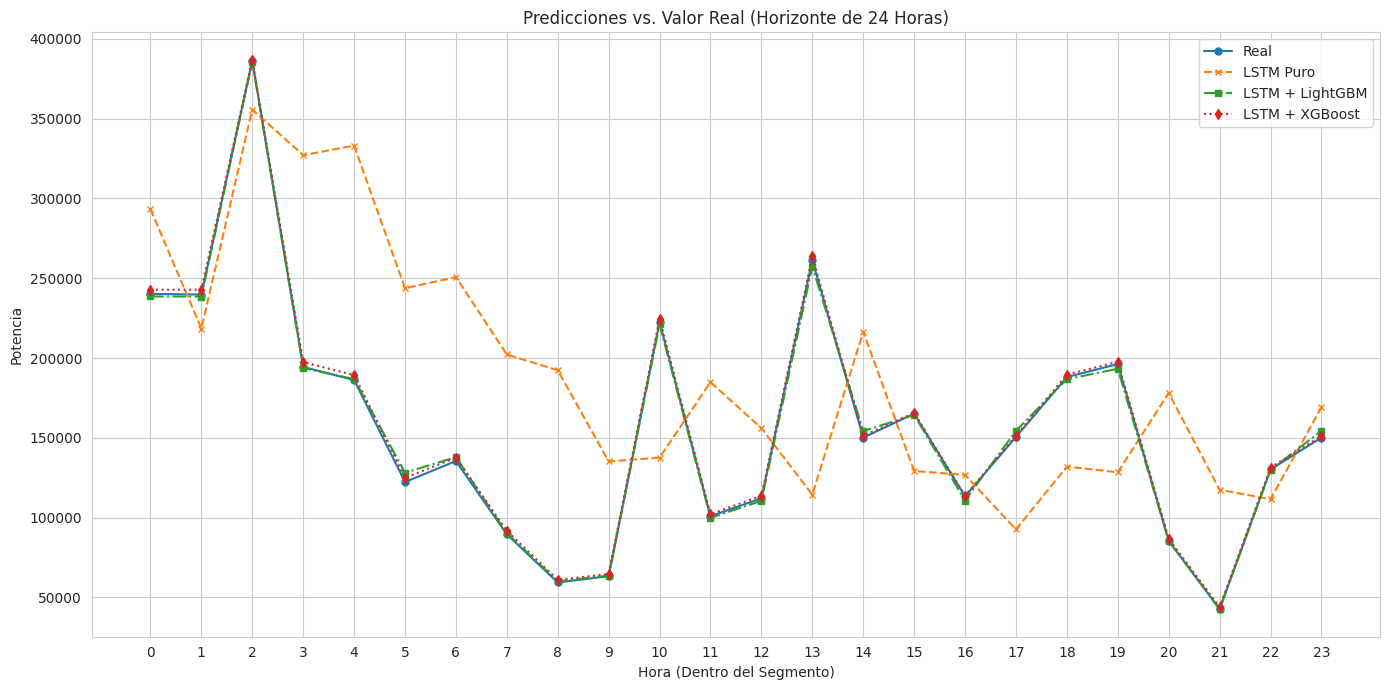

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Seleccionar un segmento de 24 horas del conjunto de prueba para visualizar
start_index = 24  # Puedes ajustar este índice para ver diferentes segmentos
end_index = start_index + 24

plt.figure(figsize=(14, 7))
plt.plot(actual_values_pure[start_index:end_index], label='Real', marker='o', linestyle='-', markersize=5)
plt.plot(lstm_predictions_pure[start_index:end_index], label='LSTM Puro', marker='x', linestyle='--', markersize=5)
plt.plot(hybrid_predictions[start_index:end_index], label='LSTM + LightGBM', marker='s', linestyle='-.', markersize=5)
plt.plot(xgboost_predictions[start_index:end_index], label='LSTM + XGBoost', marker='d', linestyle=':', markersize=5)

plt.title('Predicciones vs. Valor Real (Horizonte de 24 Horas)')
plt.xlabel('Hora (Dentro del Segmento)')
plt.ylabel('Potencia')
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.tight_layout()
plt.show()